# Predicting Bitcoin price using Deep learning

### Let's start with installing and importing and all of the libraries necessary

In [ ]:
# Install necessary libraries
!pip install pandas numpy matplotlib scikit-learn tensorflow seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

/Users/peterkocur/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Bitcoin's data

## Data loading and preprocessing

CoinMarketCap allows to download only a year worth of data per time, so I downloaded each year from 1st of September to 31st of August since the year 2014.

### Load separate pre-ETF data and merge them to one CSV

In [3]:
#load csv files to array
csv_files = [
    './jupyter notebook/data/bitcoin-test-data-1-sep2022-aug2023.csv',
    './jupyter notebook/data/bitcoin-test-data-2-sep2021-aug2022.csv',
    './jupyter notebook/data/bitcoin-test-data-3-sep2020-aug2021.csv',
    './jupyter notebook/data/bitcoin-test-data-4-sep2019-aug2020.csv',
    './jupyter notebook/data/bitcoin-test-data-5-sep2018-aug2019.csv',
    './jupyter notebook/data/bitcoin-test-data-5-sep2017-aug2018.csv',
    './jupyter notebook/data/bitcoin-test-data-5-sep2016-aug2017.csv',
    './jupyter notebook/data/bitcoin-test-data-5-sep2015-aug2016.csv',
    './jupyter notebook/data/bitcoin-test-data-5-sep2014-aug2015.csv',
]

# Read and concatenate the CSV files
df_list = [pd.read_csv(file, delimiter=';') for file in csv_files]
merged_df = pd.concat(df_list, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('./jupyter notebook/data/bitcoin-pre-etf-data.csv', index=False)

Load the CSV and transfer it to the data frame with correct columns, and convert the columns to date time

In [4]:
# Load the merged CSV file with the correct delimiter
pre_etf_data_path = './jupyter notebook/data/bitcoin-pre-etf-data.csv'
btc_pre_etf_data = pd.read_csv(pre_etf_data_path, delimiter=';', skipinitialspace=True)

# Split the single column into multiple columns
btc_pre_etf_data = btc_pre_etf_data['timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp'].str.split(',', expand=True)

# Rename the columns correctly
btc_pre_etf_data.columns = [
    'timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 
    'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp'
]

# Convert time columns to datetime
btc_pre_etf_data['timeOpen'] = pd.to_datetime(btc_pre_etf_data['timeOpen'], errors='coerce')
btc_pre_etf_data['timeClose'] = pd.to_datetime(btc_pre_etf_data['timeClose'], errors='coerce')
btc_pre_etf_data['timeHigh'] = pd.to_datetime(btc_pre_etf_data['timeHigh'], errors='coerce')
btc_pre_etf_data['timeLow'] = pd.to_datetime(btc_pre_etf_data['timeLow'], errors='coerce')
btc_pre_etf_data['timestamp'] = pd.to_datetime(btc_pre_etf_data['timestamp'], errors='coerce')

# Convert relevant columns to numeric, coercing errors to NaN
numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'marketCap']
btc_pre_etf_data[numeric_columns] = btc_pre_etf_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Make a copy of the DataFrame for trading strategy use (denormalized data)
btc_pre_etf_data_denormalized = btc_pre_etf_data.copy()

# Data normalization for numeric columns
scaler = MinMaxScaler()
btc_pre_etf_data[numeric_columns] = scaler.fit_transform(btc_pre_etf_data[numeric_columns])

# Display the first few rows of the processed DataFrame
btc_pre_etf_data.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2023-08-31 00:00:00+00:00,2023-08-31 23:59:59.999000+00:00,2023-08-31 11:43:00+00:00,2023-08-31 21:09:00+00:00,2781,0.402611,0.397276,0.386365,0.382161,0.057485,0.394937,2023-08-31 23:59:59.999000+00:00
1,2023-08-30 00:00:00+00:00,2023-08-30 23:59:59.999000+00:00,2023-08-30 00:21:00+00:00,2023-08-30 15:04:00+00:00,2781,0.408906,0.401710,0.406245,0.402429,0.046551,0.415820,2023-08-30 23:59:59.999000+00:00
2,2023-08-29 00:00:00+00:00,2023-08-29 23:59:59.999000+00:00,2023-08-29 16:28:00+00:00,2023-08-29 10:39:00+00:00,2781,0.384808,0.406510,0.388777,0.408812,0.083663,0.422386,2023-08-29 23:59:59.999000+00:00
3,2023-08-28 00:00:00+00:00,2023-08-28 23:59:59.999000+00:00,2023-08-28 12:29:00+00:00,2023-08-28 07:46:00+00:00,2781,0.384617,0.378939,0.388293,0.384753,0.031334,0.397555,2023-08-28 23:59:59.999000+00:00
4,2023-08-27 00:00:00+00:00,2023-08-27 23:59:59.999000+00:00,2023-08-27 17:02:00+00:00,2023-08-27 01:43:00+00:00,2781,0.383409,0.378455,0.389569,0.384509,0.019683,0.397289,2023-08-27 23:59:59.999000+00:00


In [5]:
# Load the CSV file with the correct delimiter
etf_data_path = './jupyter notebook/data/bitcoin-ETF-data-september-2023-august-2024.csv'
btc_etf_data = pd.read_csv(etf_data_path, delimiter=';', skipinitialspace=True)

# Convert time columns to datetime
btc_etf_data['timeOpen'] = pd.to_datetime(btc_etf_data['timeOpen'], errors='coerce')
btc_etf_data['timeClose'] = pd.to_datetime(btc_etf_data['timeClose'], errors='coerce')
btc_etf_data['timeHigh'] = pd.to_datetime(btc_etf_data['timeHigh'], errors='coerce')
btc_etf_data['timeLow'] = pd.to_datetime(btc_etf_data['timeLow'], errors='coerce')
btc_etf_data['timestamp'] = pd.to_datetime(btc_etf_data['timestamp'], errors='coerce')

# Convert relevant columns to numeric, coercing errors to NaN
numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'marketCap']
btc_etf_data[numeric_columns] = btc_etf_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

btc_etf_data_denormalized = btc_etf_data.copy()
# Data normalization for numeric columns
scaler = MinMaxScaler()
btc_etf_data[numeric_columns] = scaler.fit_transform(btc_etf_data[numeric_columns])

# Display the first few rows of the processed DataFrame
btc_etf_data.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2024-08-30 00:00:00+00:00,2024-08-30 23:59:59.999000+00:00,2024-08-30 12:31:00+00:00,2024-08-30 16:28:00+00:00,2781,0.714292,0.710739,0.707663,0.708602,0.260097,0.715844,2024-08-30 23:59:59.999000+00:00
1,2024-08-29 00:00:00+00:00,2024-08-29 23:59:59.999000+00:00,2024-08-29 15:35:00+00:00,2024-08-29 22:10:00+00:00,2781,0.706755,0.737616,0.729594,0.714210,0.259443,0.721436,2024-08-29 23:59:59.999000+00:00
2,2024-08-28 00:00:00+00:00,2024-08-28 23:59:59.999000+00:00,2024-08-28 10:00:00+00:00,2024-08-28 16:24:00+00:00,2781,0.716782,0.717829,0.710295,0.706686,0.337241,0.713872,2024-08-28 23:59:59.999000+00:00
3,2024-08-27 00:00:00+00:00,2024-08-27 23:59:59.999000+00:00,2024-08-27 01:36:00+00:00,2024-08-27 22:16:00+00:00,2781,0.787147,0.779935,0.715167,0.716629,0.325803,0.723867,2024-08-27 23:59:59.999000+00:00
4,2024-08-26 00:00:00+00:00,2024-08-26 23:59:59.999000+00:00,2024-08-26 00:08:00+00:00,2024-08-26 23:56:00+00:00,2781,0.817667,0.806639,0.817159,0.787090,0.215617,0.794216,2024-08-26 23:59:59.999000+00:00


In [6]:
# Check for missing values
print("Pre-ETF Missing values:\n", btc_pre_etf_data.isnull().sum())
print("Post-ETF Missing values:\n", btc_etf_data.isnull().sum())

Pre-ETF Missing values:
 timeOpen     0
timeClose    0
timeHigh     0
timeLow      0
name         0
open         0
high         0
low          0
close        0
volume       0
marketCap    0
timestamp    0
dtype: int64
Post-ETF Missing values:
 timeOpen     0
timeClose    0
timeHigh     0
timeLow      0
name         0
open         0
high         0
low          0
close        0
volume       0
marketCap    0
timestamp    0
dtype: int64


### Plot Bitcoin's closing price to visually check if it's correct

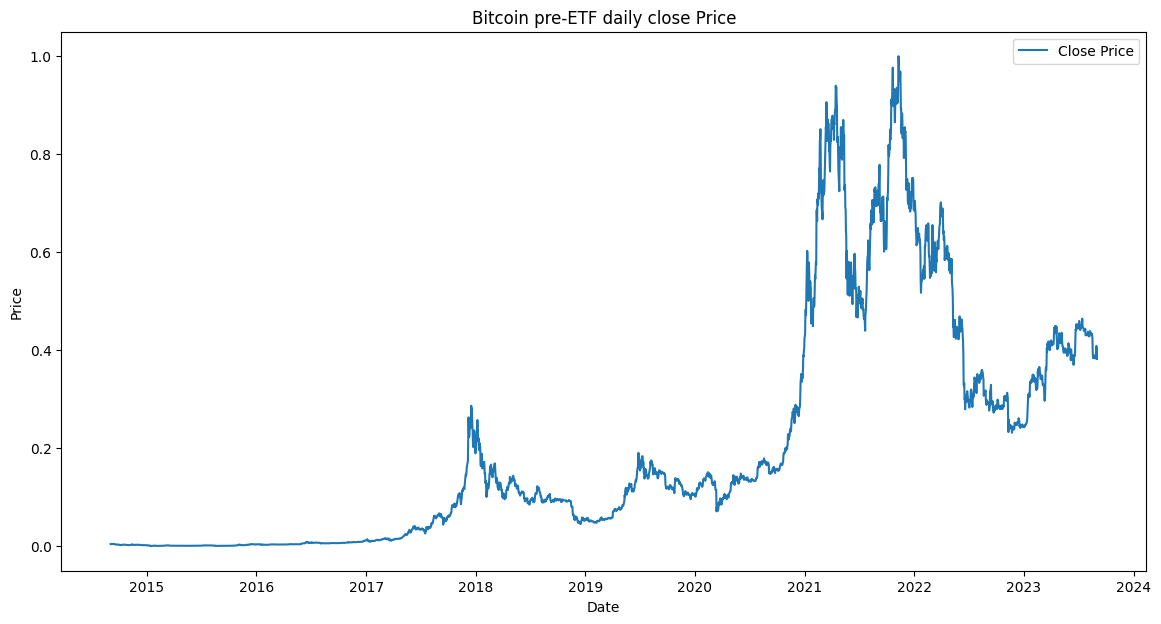

In [7]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(btc_pre_etf_data['timeClose'], btc_pre_etf_data['close'], label='Close Price')
plt.title('Bitcoin pre-ETF daily close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

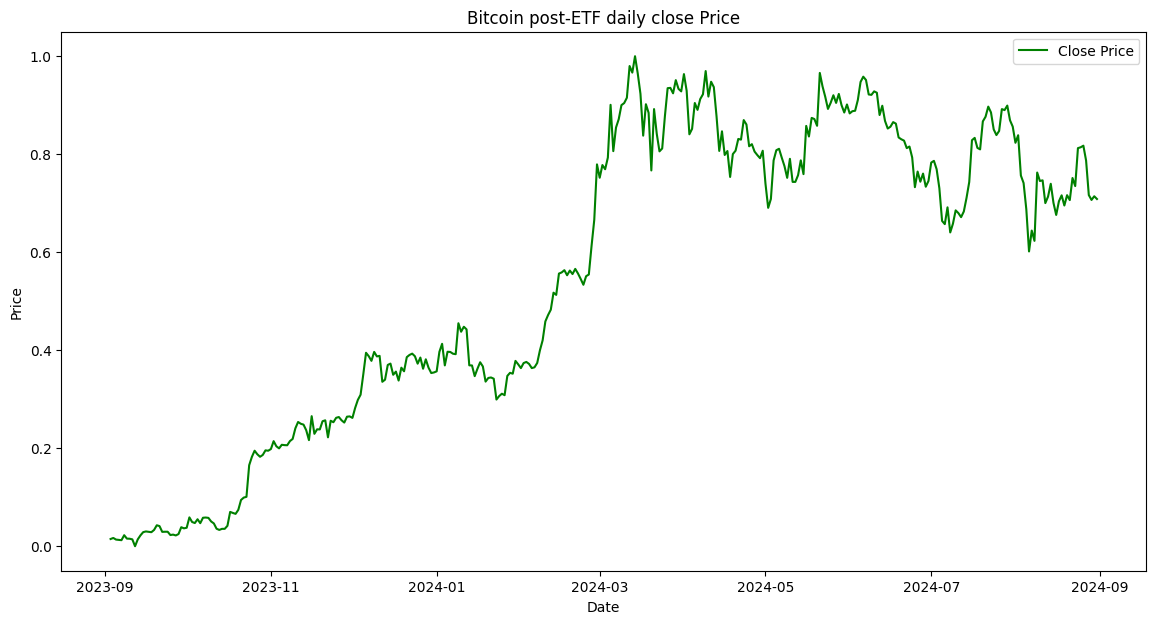

In [8]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(btc_etf_data['timeClose'], btc_etf_data['close'], label='Close Price', color='green')
plt.title('Bitcoin post-ETF daily close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Add Technical indicators 

In [9]:
# Add technical indicators
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

def calculate_rsi(data, window):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
#pre-ETF data
btc_pre_etf_data['SMA'] = calculate_sma(btc_pre_etf_data['close'], 20)
btc_pre_etf_data['RSI'] = calculate_rsi(btc_pre_etf_data['close'], 14)

#post-ETF data
btc_etf_data['SMA'] = calculate_sma(btc_etf_data['close'], 20)
btc_etf_data['RSI'] = calculate_rsi(btc_etf_data['close'], 14)

Check if there are any missing values for when we added technical indicators

In [10]:
print("Pre-ETF Missing values:\n", btc_pre_etf_data.isnull().sum())
print("Post-ETF Missing values:\n", btc_etf_data.isnull().sum())

Pre-ETF Missing values:
 timeOpen      0
timeClose     0
timeHigh      0
timeLow       0
name          0
open          0
high          0
low           0
close         0
volume        0
marketCap     0
timestamp     0
SMA          19
RSI          13
dtype: int64
Post-ETF Missing values:
 timeOpen      0
timeClose     0
timeHigh      0
timeLow       0
name          0
open          0
high          0
low           0
close         0
volume        0
marketCap     0
timestamp     0
SMA          19
RSI          13
dtype: int64


Due to the nature of the calculation for moving averages, the first n-1 (20 and 14) records won't have any RSI or SMA values. This is expected, so it's okay to drop them.

In [11]:
# Forward and backward fill NaN values in SMA and RSI
btc_pre_etf_data['SMA'] = btc_pre_etf_data['SMA'].ffill().bfill()
btc_pre_etf_data['RSI'] = btc_pre_etf_data['RSI'].ffill().bfill()

btc_etf_data['SMA'] = btc_etf_data['SMA'].ffill().bfill()
btc_etf_data['RSI'] = btc_etf_data['RSI'].ffill().bfill()

# Ensure no NaN values are present after filling
print("Missing values after fill:\n", btc_pre_etf_data.isnull().sum())
print("Missing values:\n", btc_etf_data.isnull().sum())


Missing values after fill:
 timeOpen     0
timeClose    0
timeHigh     0
timeLow      0
name         0
open         0
high         0
low          0
close        0
volume       0
marketCap    0
timestamp    0
SMA          0
RSI          0
dtype: int64
Missing values:
 timeOpen     0
timeClose    0
timeHigh     0
timeLow      0
name         0
open         0
high         0
low          0
close        0
volume       0
marketCap    0
timestamp    0
SMA          0
RSI          0
dtype: int64


# Pre-ETF approval Bitcoin datasets

## LSTM Model

### Preparing datasets for training

We will use a standard 80/20 split for training and testing data.

The dataset is split into the features, which are different prices per day, and technical indicators. The target variable is high price, because we are not interested in the closing price that day. We are primarily interested in the predicted price being hit at any point in time during that day. This is where I profit target order will be filled.

In [12]:
# Prepare the dataset for training
X = btc_pre_etf_data[['open', 'close', 'low', 'volume', 'marketCap']]
y = btc_pre_etf_data['high']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data to be 3D for LSTM [samples, time steps, features]
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

### Train the model

A deep learning model based on Long Short-Term Memory (LSTM) networks. This model is designed to capture temporal dependencies and patterns in time series data, making it well-suited for financial predictions.

Starting off optimizing for balance between complexity and computation speed
1. 50 neurons per layer
2. 10 epochs to minimize the risk of overfitting
3. Dense layer is set to 1, as we are only interested in predicting single value = Highest Prices
4. For the optimizer, I chosed Adam, which is widely-used and common optimizer.
5. 32 for batch size, which is again a common choice that balances training speed and stability of gradient descent process.


In [13]:
# Initialize the LSTM model
lstm_model = Sequential()

# Add an Input layer to specify input shape
lstm_model.add(Input(shape=(X_train_lstm.shape[1], 1)))

# Add the first LSTM layer
lstm_model.add(LSTM(units=50, return_sequences=True))

# Add a second LSTM layer
lstm_model.add(LSTM(units=50))

# Add a Dense layer with 1 unit for the output (predicted high price)
lstm_model.add(Dense(1))

# Compile the LSTM model using Adam optimizer and mean squared error loss
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model on the training data
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0405 
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3398e-04
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2947e-05
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0803e-05
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7930e-05
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9848e-05
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7485e-05
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4726e-05
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4660e-05
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1255e-05


### Run predictions and evaluate LSTM Model

In [14]:
# Predictions
lstm_predictions = lstm_model.predict(X_test_lstm)

# Evaluate models
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)

# Print the evaluation metrics for the LSTM model
print(f'LSTM MAE: {lstm_mae:.4f}')
print(f'LSTM RMSE: {lstm_rmse:.4f}')
print(f'LSTM R-squared: {lstm_r2:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM MAE: 0.0048
LSTM RMSE: 0.0067
LSTM R-squared: 0.9992


## LSTM Evaluation

1. **MAE (0.0048):** The model’s average prediction error is very low, indicating high accuracy in predicting actual values.
2. **RMSE (0.0067):** The model’s error magnitude is small, suggesting precise predictions with minimal large deviations.
3. **R-squared (0.9992):** The model explains 99.92% of the variance in the target variable, indicating an excellent fit to the data.

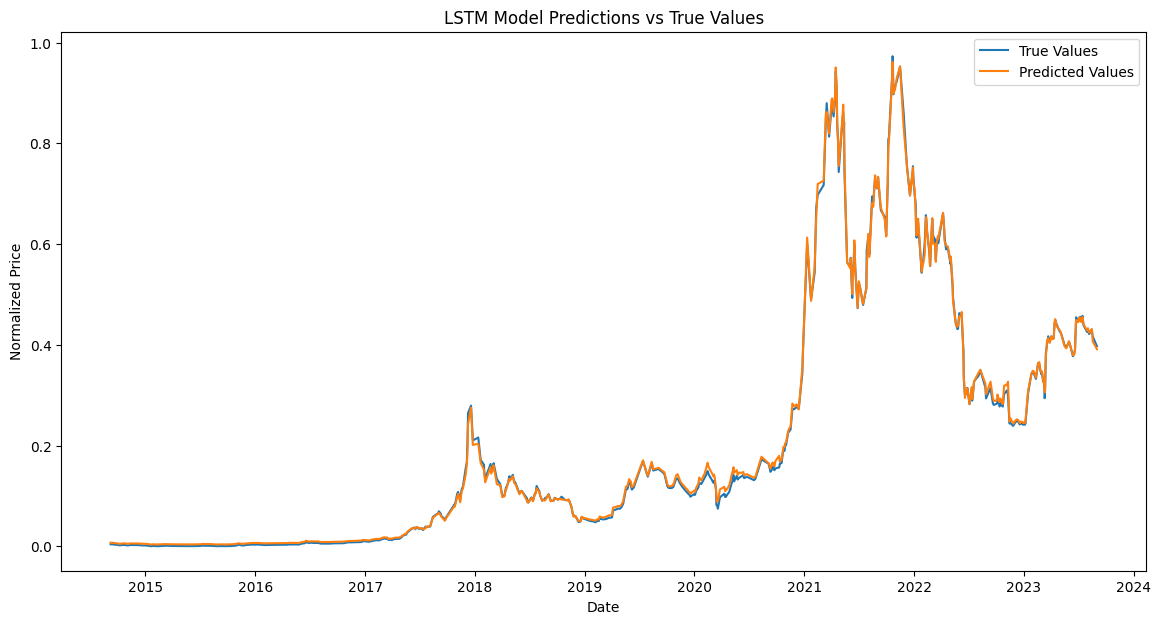

In [15]:
# Ensure the test indices are sorted to maintain chronological order
sorted_test_indices = np.sort(y_test.index)

# Use sorted indices to reorder the predictions and true values for plotting
sorted_y_test = y_test.loc[sorted_test_indices].values
sorted_predictions = lstm_predictions[np.argsort(y_test.index)]

# Plot results for LSTM model with sorted data
plt.figure(figsize=(14, 7))

# Plot true values and predictions over the full date range
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_y_test, label='True Values')
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_predictions, label='Predicted Values')

plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

## GRU Model

### Preparing datasets for training

In [16]:
# Prepare the dataset for training
X = btc_pre_etf_data[['open', 'close', 'low', 'volume', 'marketCap']]
y = btc_pre_etf_data['high']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data to be 3D for GRU [samples, time steps, features]
X_train_gru = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_gru = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

### Train the GRU model

A deep learning model based on Gated Recurrent Units (GRU) networks. This model is designed to capture temporal dependencies and patterns in time series data, similar to LSTM networks, but with a simpler architecture and fewer parameters, making it more efficient for certain tasks such as financial predictions.

Starting off optimizing for a balance between model complexity and computational efficiency:

1. 50 neurons per layer: To capture the complexity of Bitcoin price movements while maintaining computational efficiency.
2. 10 epochs: Chosen to minimize the risk of overfitting while ensuring adequate training.
3. Dense layer is set to 1: As we are only interested in predicting a single value, the highest price.
4. Adam optimizer: A widely-used and efficient optimizer for training deep learning models.
5. Batch size of 32: Selected to balance training speed and the stability of the gradient descent process.

In [17]:
gru_model = Sequential()

# Add an Input layer to specify input shape
gru_model.add(Input(shape=(X_train_gru.shape[1], 1)))

# Add the first GRU layer
gru_model.add(GRU(units=50, return_sequences=True))

# Add a second GRU layer
gru_model.add(GRU(units=50))

# Add a Dense layer with 1 unit for the output (predicted high price)
gru_model.add(Dense(1))

# Compile the GRU model using Adam optimizer and mean squared error loss
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model on the training data
gru_model.fit(X_train_gru, y_train, epochs=10, batch_size=32)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166  
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4497e-04
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0624e-04
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3353e-04
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0909e-04
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8183e-05
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7467e-05
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1350e-04
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0776e-04
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1606e-04


### Run predictions and evaluate GRU Model

In [18]:
# Make predictions with the GRU model
gru_predictions = gru_model.predict(X_test_gru)

# Evaluate the GRU model
gru_mae = mean_absolute_error(y_test, gru_predictions)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_predictions))
gru_r2 = r2_score(y_test, gru_predictions)

# Print the evaluation metrics for the GRU model
print(f'GRU MAE: {gru_mae:.4f}')
print(f'GRU RMSE: {gru_rmse:.4f}')
print(f'GRU R-squared: {gru_r2:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
GRU MAE: 0.0059
GRU RMSE: 0.0094
GRU R-squared: 0.9985


## GRU Evaluation

1. **MAE (0.0058):** The model’s average prediction error is low, suggesting reasonably high accuracy in predicting actual values.
2. **RMSE (0.0087):** The model’s error magnitude remains small, indicating precise predictions with minimal significant deviations.
3. **R-squared (0.9985):** The model explains 99.85% of the variance in the target variable, demonstrating an excellent fit to the data.

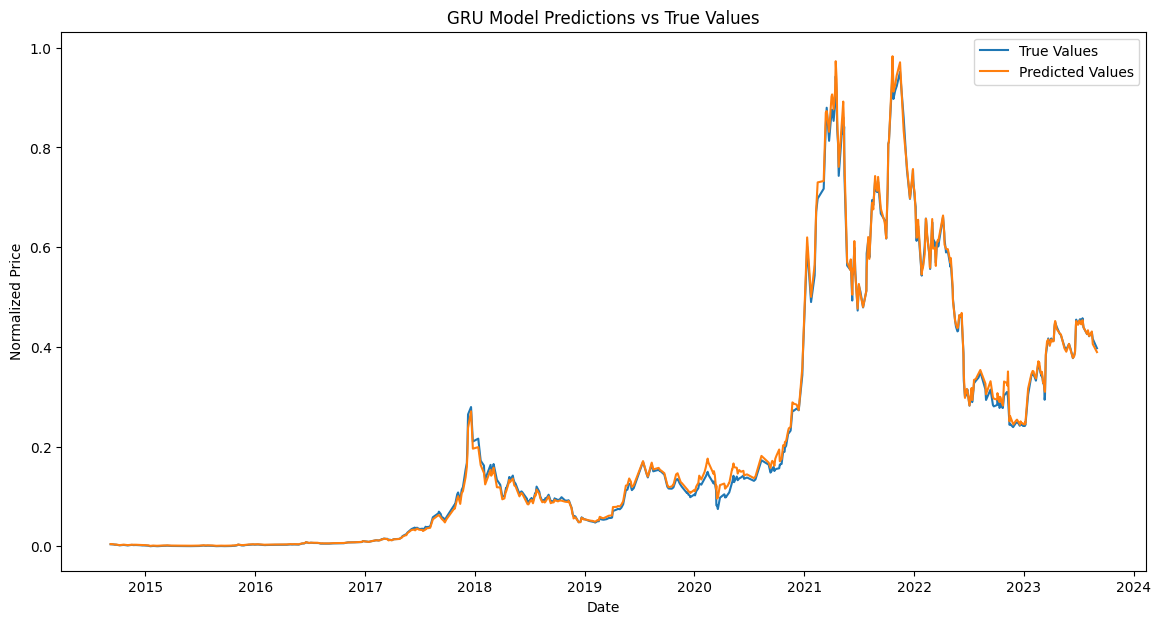

In [19]:
# Ensure the test indices are sorted to maintain chronological order
sorted_test_indices = np.sort(y_test.index)

# Use sorted indices to reorder the predictions and true values for plotting
sorted_y_test = y_test.loc[sorted_test_indices].values
sorted_predictions = gru_predictions[np.argsort(y_test.index)]

plt.figure(figsize=(14, 7))

# Plot true values and predictions over the full date range
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_y_test, label='True Values')
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_predictions, label='Predicted Values')

plt.title('GRU Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

## CNN model

### Preparing datasets for training

In [20]:
# Prepare the dataset for training
X = btc_pre_etf_data[['open', 'close', 'low', 'volume', 'marketCap']]
y = btc_pre_etf_data['high']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data to be 3D for CNN [samples, time steps, features]
X_train_cnn = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

### Train the CNN model

A deep learning model based on Convolutional Neural Networks (CNNs). This model is designed to capture local patterns and trends in time series data, making it suitable for financial predictions by recognizing patterns in sequences.

Starting off optimizing for a balance between complexity and computational efficiency:

1. 64 filters with a kernel size of 2: To effectively capture local dependencies in the time series data.
2. MaxPooling layer: Added to reduce the dimensionality of the feature maps and prevent overfitting.
3. Dense layer with 50 units: To learn complex features from the extracted patterns.
4. Dense output layer set to 1: As we are predicting a single value, the highest price.
5. Adam optimizer: Chosen for its effectiveness and common usage in deep learning models.
6. Batch size of 32: A common choice to balance training speed and the stability of the gradient descent process.

In [21]:
# Initialize the CNN model
cnn_model = Sequential()

# Add an Input layer to specify input shape
cnn_model.add(Input(shape=(X_train_cnn.shape[1], 1)))

# Add the first Convolutional layer with 64 filters and kernel size of 2
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

# Add a MaxPooling layer to downsample the input
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output before feeding it into the Dense layer
cnn_model.add(Flatten())

# Add a Dense layer with 50 units
cnn_model.add(Dense(50, activation='relu'))

# Add a Dense output layer with 1 unit (for predicting the target variable)
cnn_model.add(Dense(1))

# Compile the CNN model using Adam optimizer and mean squared error loss
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the CNN model on the training data
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.0239 
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 6.7032e-05
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - loss: 8.1677e-05
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - loss: 4.4998e-05
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - loss: 5.8411e-05
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - loss: 2.9934e-05
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 2.9042e-05
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 3.5406e-05
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - loss: 4.8992e-05
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 2.6124e-05


### Run predictions and evaluate CNN Model

In [22]:
# Make predictions with the CNN model
cnn_predictions = cnn_model.predict(X_test_cnn)

# Evaluate the CNN model
cnn_mae = mean_absolute_error(y_test, cnn_predictions)
cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_predictions))
cnn_r2 = r2_score(y_test, cnn_predictions)

# Print the evaluation metrics for the CNN model
print(f'CNN MAE: {cnn_mae:.4f}')
print(f'CNN RMSE: {cnn_rmse:.4f}')
print(f'CNN R-squared: {cnn_r2:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
CNN MAE: 0.0036
CNN RMSE: 0.0060
CNN R-squared: 0.9994


## CNN Evaluation

1. **MAE (0.0036):** The model’s average prediction error is low, indicating reasonably high accuracy in predicting actual values.
2. **RMSE (0.0060):** The model’s error magnitude is small, suggesting precise predictions with minimal significant deviations.
3. **R-squared (0.9994):** The model explains 99.94% of the variance in the target variable, indicating an excellent fit to the data.

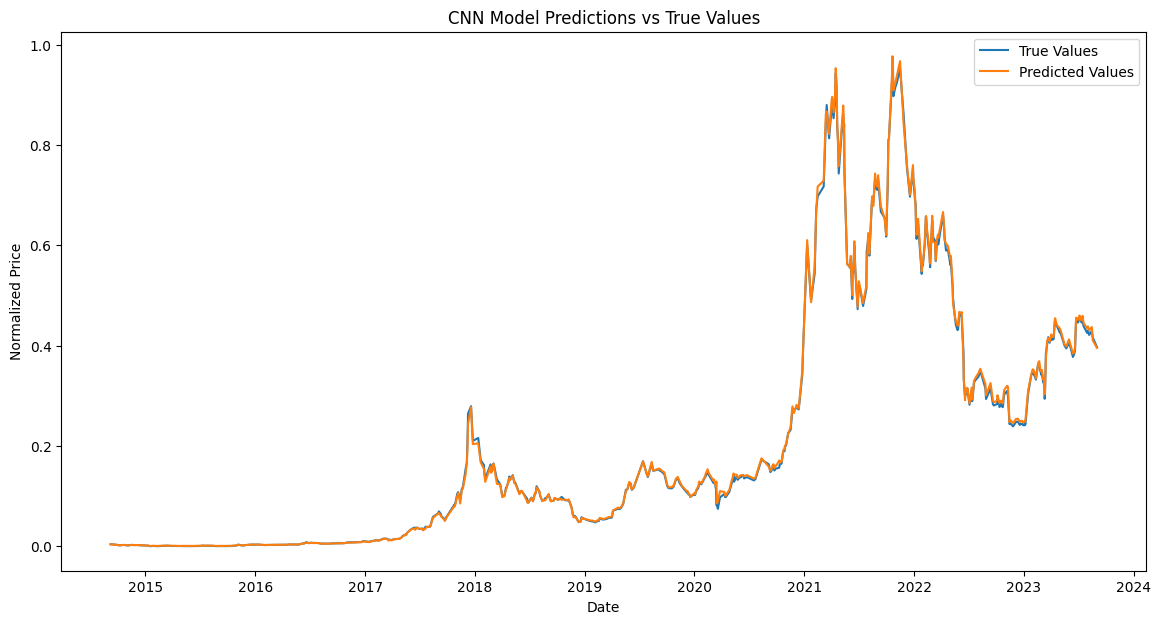

In [23]:
# Ensure the test indices are sorted to maintain chronological order
sorted_test_indices = np.sort(y_test.index)

# Use sorted indices to reorder the predictions and true values for plotting
sorted_y_test = y_test.loc[sorted_test_indices].values
sorted_predictions = cnn_predictions[np.argsort(y_test.index)]

plt.figure(figsize=(14, 7))

# Plot true values and predictions over the full date range
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_y_test, label='True Values')
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_predictions, label='Predicted Values')

plt.title('CNN Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

## RFR Model

### Preparing datasets for training

In [24]:
# Prepare the dataset for training
X = btc_pre_etf_data[['open', 'close', 'low', 'volume', 'marketCap']]
y = btc_pre_etf_data['high']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Train the RFR model

A machine learning model based on the Random Forest Regressor (RFR). This model is designed to capture non-linear patterns in time series data through an ensemble of decision trees, making it robust against overfitting and well-suited for financial predictions.

Starting off optimizing for a balance between model complexity and interoperability:

1. 100 estimators (trees): To ensure a robust model that captures a wide range of patterns without overfitting.
2. Max depth set to None: Allowing the trees to expand fully until all leaves are pure or contain less than the minimum samples required for a split.
3. Mean Squared Error (MSE) as the criterion: A standard loss function for regression that measures the average squared difference between actual and predicted values.
4. Random state set to 42: To ensure reproducibility of results.
5. Default settings for other hyperparameters: Providing a balance between simplicity and performance

In [25]:
# Initialize the Random Forest Regressor model
rfr_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, criterion='squared_error')

# Train the Random Forest Regressor on the training data
rfr_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Run predictions and evaluate RFR Model

In [26]:
# Make predictions with the Random Forest Regressor
rfr_predictions = rfr_model.predict(X_test)

# Evaluate the Random Forest Regressor model
rfr_mae = mean_absolute_error(y_test, rfr_predictions)
rfr_rmse = np.sqrt(mean_squared_error(y_test, rfr_predictions))
rfr_r2 = r2_score(y_test, rfr_predictions)

# Print the evaluation metrics for the Random Forest Regressor model
print(f'RFR MAE: {rfr_mae:.4f}')
print(f'RFR RMSE: {rfr_rmse:.4f}')
print(f'RFR R-squared: {rfr_r2:.4f}')

RFR MAE: 0.0022
RFR RMSE: 0.0054
RFR R-squared: 0.9995


1. **MAE (0.0022):** The model’s average prediction error is very low, indicating high accuracy in predicting actual values.
2. **RMSE (0.0054):** The model’s error magnitude is quite small, suggesting precise predictions with minimal significant deviations.
3. **R-squared (0.9995):** The model explains 99.95% of the variance in the target variable, demonstrating an excellent fit to the data.

Overall, the Random Forest Regressor model provides superior performance with lower prediction errors and a higher R-squared value compared to the other models, making it a robust choice for this financial prediction task.

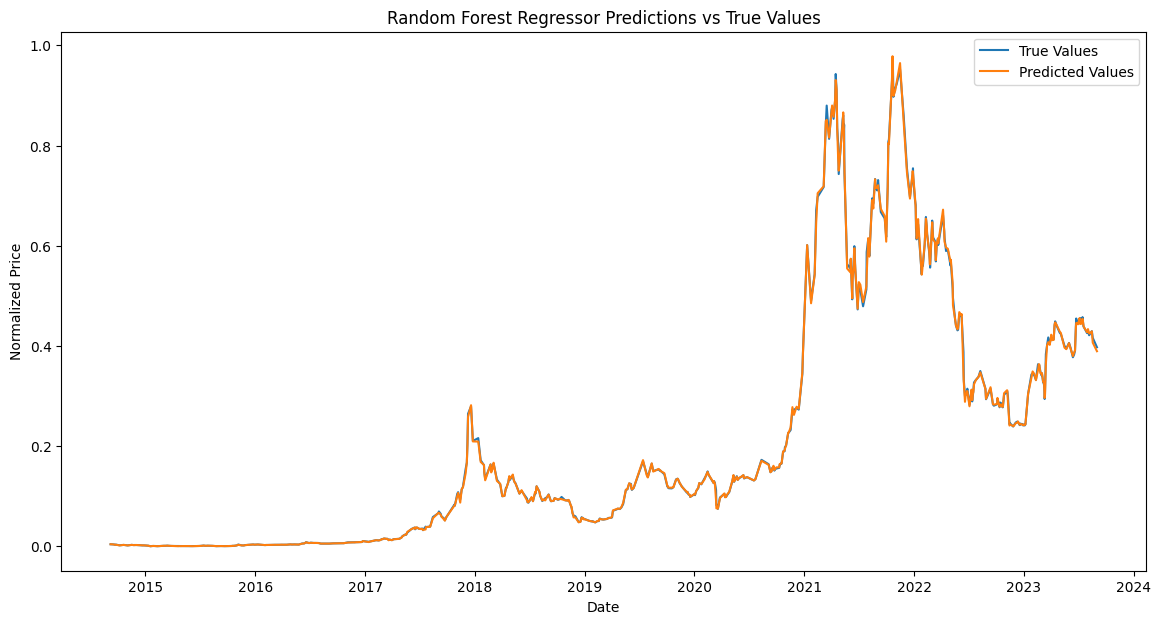

In [27]:
# Plot results for the Random Forest Regressor model
plt.figure(figsize=(14, 7))

# Ensure the test indices are sorted to maintain chronological order
sorted_test_indices = np.sort(y_test.index)

# Use sorted indices to reorder the predictions and true values for plotting
sorted_y_test = y_test.loc[sorted_test_indices].values
sorted_predictions = rfr_predictions[np.argsort(y_test.index)]

plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_y_test, label='True Values')
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_predictions, label='Predicted Values')

plt.title('Random Forest Regressor Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

## Models Comparinson

We can see that  overall, all models are predicting price relativelly well. However, the 10-year view is not sufficient for the visual comparisson, so we will move to a yearly timeframe too see it better.

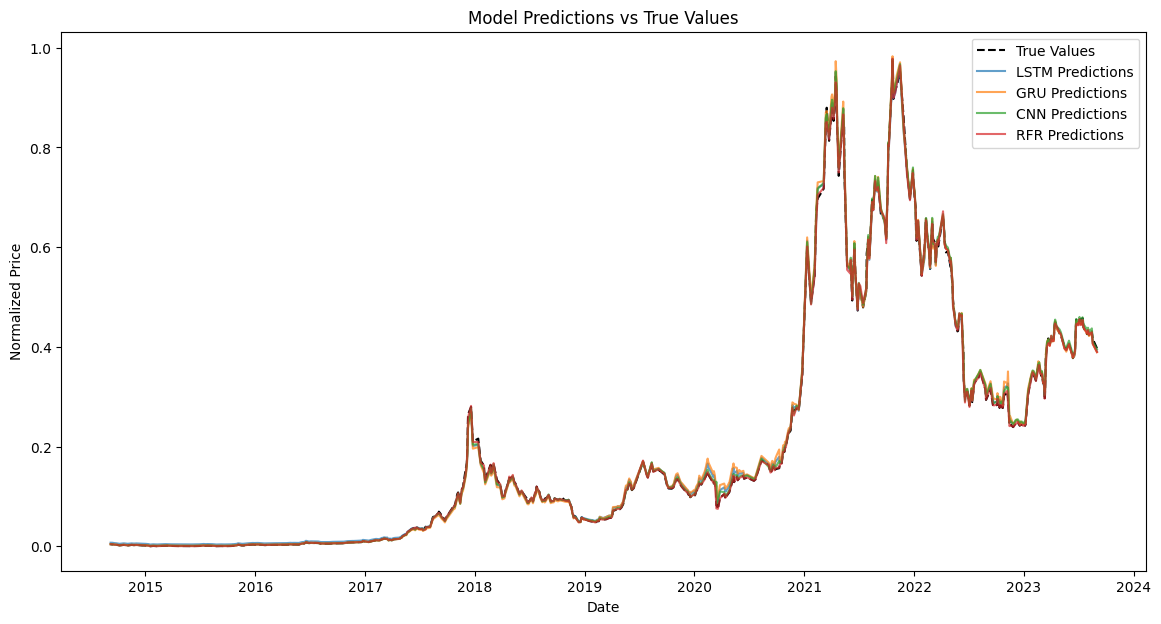

In [28]:
# Ensure the test indices are sorted to maintain chronological order
sorted_test_indices = np.sort(y_test.index)

# Use sorted indices to reorder the predictions and true values for plotting
sorted_y_test = y_test.loc[sorted_test_indices].values

# Reorder predictions using sorted indices for consistent comparison
sorted_lstm_predictions = lstm_predictions[np.argsort(y_test.index)]
sorted_gru_predictions = gru_predictions[np.argsort(y_test.index)]
sorted_cnn_predictions = cnn_predictions[np.argsort(y_test.index)]
sorted_rfr_predictions = rfr_predictions[np.argsort(y_test.index)]

plt.figure(figsize=(14, 7))

# Plot true values
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_y_test, label='True Values', color='black', linestyle='--')

# Plot predictions from each model
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_lstm_predictions, label='LSTM Predictions', alpha=0.7)
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_gru_predictions, label='GRU Predictions', alpha=0.7)
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_cnn_predictions, label='CNN Predictions', alpha=0.7)
plt.plot(btc_pre_etf_data.loc[sorted_test_indices, 'timeClose'], sorted_rfr_predictions, label='RFR Predictions', alpha=0.7)

# Adding titles and labels
plt.title('Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()

# Show the plot
plt.show()

In the one year span, the differences are much more visible, with RFR clearly performing the best.

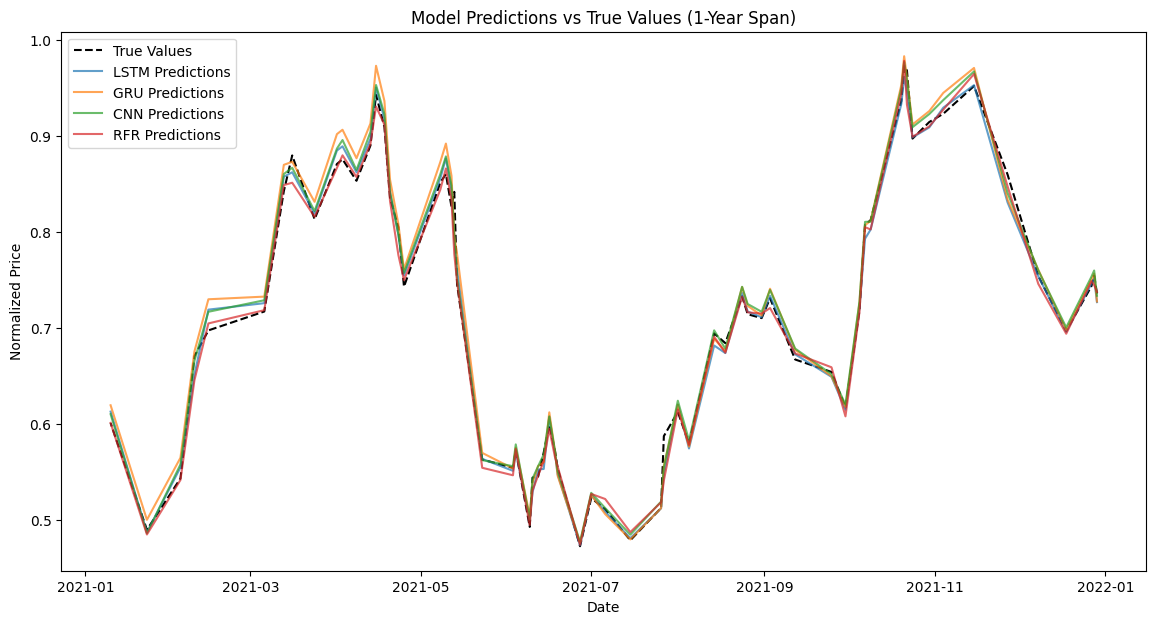

In [29]:
# Specify the start and end dates for the 1-year period
start_date = '2021-01-01'
end_date = '2022-01-01'

# Filter the original data to include only the specified date range
filtered_data = btc_pre_etf_data[(btc_pre_etf_data['timeClose'] >= start_date) & 
                                 (btc_pre_etf_data['timeClose'] <= end_date)]

# Ensure data is sorted by 'timeClose'
filtered_data = filtered_data.sort_values(by='timeClose')

# Find common indices between filtered_data and y_test
common_indices = filtered_data.index.intersection(y_test.index)

# Sort these indices to ensure proper chronological order
common_indices = common_indices.sort_values()

# Use common_indices to get aligned y_test and model predictions
filtered_y_test = y_test.loc[common_indices].values
filtered_lstm_predictions = lstm_predictions[y_test.index.get_indexer(common_indices)].flatten()
filtered_gru_predictions = gru_predictions[y_test.index.get_indexer(common_indices)].flatten()
filtered_cnn_predictions = cnn_predictions[y_test.index.get_indexer(common_indices)].flatten()
filtered_rfr_predictions = rfr_predictions[y_test.index.get_indexer(common_indices)].flatten()

plt.figure(figsize=(14, 7))

# Plot true values as a continuous line within the filtered date range
plt.plot(filtered_data.loc[common_indices, 'timeClose'], filtered_y_test, label='True Values', color='black', linestyle='--')

# Plot predictions from each model as continuous lines within the filtered date range
plt.plot(filtered_data.loc[common_indices, 'timeClose'], filtered_lstm_predictions, label='LSTM Predictions', alpha=0.7)
plt.plot(filtered_data.loc[common_indices, 'timeClose'], filtered_gru_predictions, label='GRU Predictions', alpha=0.7)
plt.plot(filtered_data.loc[common_indices, 'timeClose'], filtered_cnn_predictions, label='CNN Predictions', alpha=0.7)
plt.plot(filtered_data.loc[common_indices, 'timeClose'], filtered_rfr_predictions, label='RFR Predictions', alpha=0.7)

# Adding titles and labels
plt.title('Model Predictions vs True Values (1-Year Span)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()

# Show the plot
plt.show()

## Error comparisson

- **Box Plot of Errors (Left Plot):** This plot illustrates the distribution of errors for each model. The box represents the interquartile range (IQR), which contains the middle 50% of the error data. The line within the box indicates the median error. The “whiskers” show the range of errors, excluding outliers, which are represented as individual points outside the whiskers. This plot reveals the spread and central tendency of errors, highlighting that the LSTM model has a smaller spread of errors, indicating more consistent predictions, while the GRU, CNN, and RFR models show more variability and potential outliers.
- **Error Distribution (Right Plot):** This plot shows the density of errors for each model using histograms and kernel density estimates (KDE). It demonstrates how frequently each error value occurs. The error distribution provides insights into the bias of the models’ predictions. A more concentrated distribution around zero indicates less biased predictions. From this plot, LSTM has a relatively symmetric error distribution around zero, suggesting minimal bias, while other models like CNN and RFR show a wider spread, indicating more frequent larger errors.

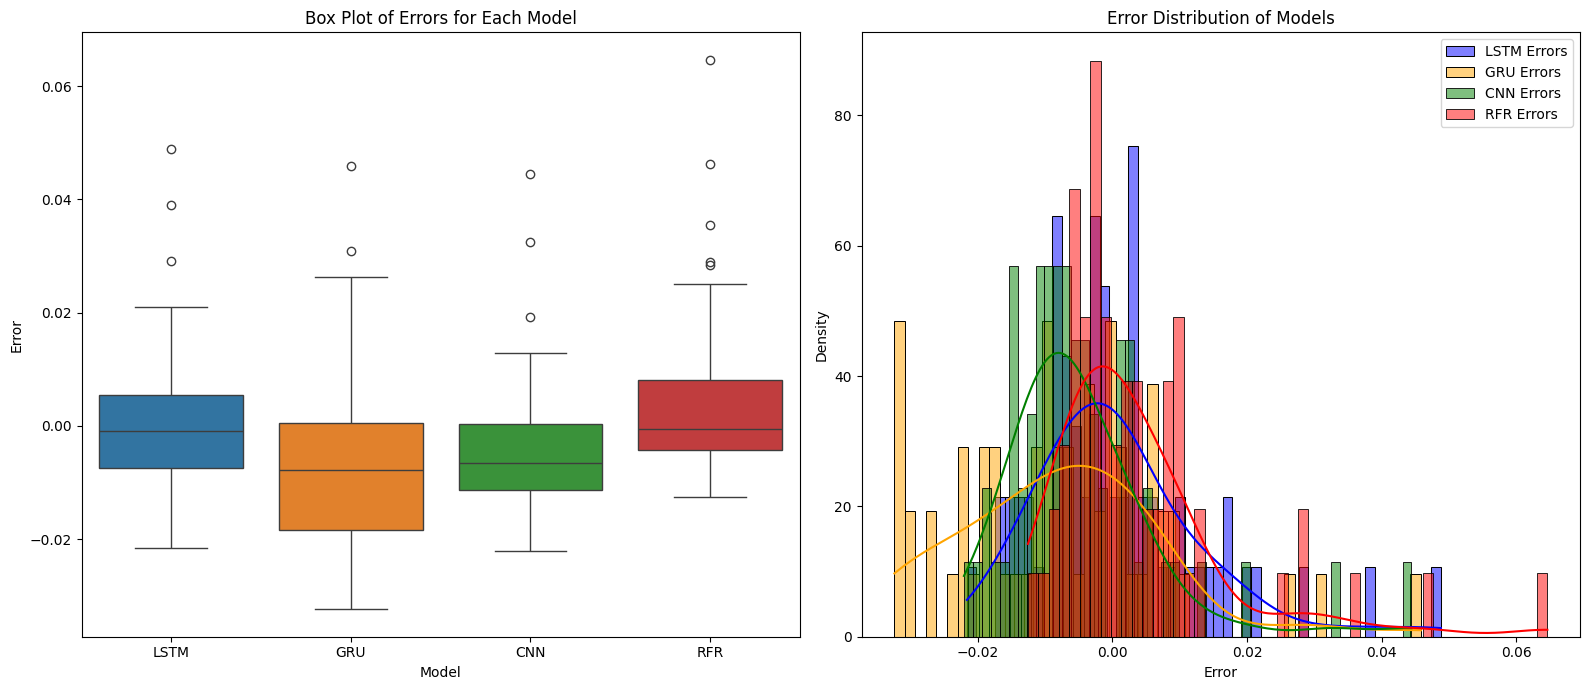

In [30]:
# Calculate errors for each model (if not already calculated)
lstm_errors = filtered_y_test - filtered_lstm_predictions
gru_errors = filtered_y_test - filtered_gru_predictions
cnn_errors = filtered_y_test - filtered_cnn_predictions
rfr_errors = filtered_y_test - filtered_rfr_predictions

# Create a DataFrame for box plotting
error_data = pd.DataFrame({
    'LSTM': lstm_errors,
    'GRU': gru_errors,
    'CNN': cnn_errors,
    'RFR': rfr_errors
})

# Set up a two-column subplot layout
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot Box Plot of Errors
sns.boxplot(data=error_data, ax=axes[0])
axes[0].set_title('Box Plot of Errors for Each Model')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Error')

# Plot Error Distribution (Density Plot)
sns.histplot(lstm_errors, bins=50, color='blue', label='LSTM Errors', kde=True, stat='density', ax=axes[1])
sns.histplot(gru_errors, bins=50, color='orange', label='GRU Errors', kde=True, stat='density', ax=axes[1])
sns.histplot(cnn_errors, bins=50, color='green', label='CNN Errors', kde=True, stat='density', ax=axes[1])
sns.histplot(rfr_errors, bins=50, color='red', label='RFR Errors', kde=True, stat='density', ax=axes[1])

axes[1].set_title('Error Distribution of Models')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Density')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Bitcoin post-ETF data

With Bitcoins ETF approval the insitution money came heavily into the market. This can be observed by looking at the price development from September 2023, when there were rumors about ETF approval. Bitcoin's ETF was approved in January 2024; however, financial markets usually already take into account these fundaments. Therefore, we will start from September 2023. The hypotesis is, that the market dynamics could change and therefore change the price predictions. We will test models on this dataset to see if there's any improvement in the predictions, and if our trading models would perform better starting from September 2023.

### Data preparation

In [31]:
# Prepare the dataset for training
X = btc_etf_data[['open', 'close', 'low', 'volume', 'marketCap']]
y = btc_etf_data['high']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### LSTM Model

In [32]:
# Reshape the input data to be 3D for LSTM [samples, time steps, features]
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# Initialize the LSTM model
lstm_model = Sequential()

# Add an Input layer to specify input shape
lstm_model.add(Input(shape=(X_train_lstm.shape[1], 1)))

# Add the first LSTM layer
lstm_model.add(LSTM(units=50, return_sequences=True))

# Add a second LSTM layer
lstm_model.add(LSTM(units=50))

# Add a Dense layer with 1 unit for the output (predicted high price)
lstm_model.add(Dense(1))

# Compile the LSTM model using Adam optimizer and mean squared error loss
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model on the training data
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)

# Predictions
lstm_predictions = lstm_model.predict(X_test_lstm)

# Evaluate models
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)

# Print the evaluation metrics for the LSTM model
print(f'LSTM MAE: {lstm_mae:.4f}')
print(f'LSTM RMSE: {lstm_rmse:.4f}')
print(f'LSTM R-squared: {lstm_r2:.4f}')

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3402  
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1286
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0279
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0178
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2152e-04
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9442e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
LSTM MAE: 0.0199
LSTM RMSE: 0.0244
LSTM R-squared: 0.9942


### GRU Model

In [33]:
# Reshape the input data to be 3D for GRU [samples, time steps, features]
X_train_gru = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_gru = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

gru_model = Sequential()

# Add an Input layer to specify input shape
gru_model.add(Input(shape=(X_train_gru.shape[1], 1)))

# Add the first GRU layer
gru_model.add(GRU(units=50, return_sequences=True))

# Add a second GRU layer
gru_model.add(GRU(units=50))

# Add a Dense layer with 1 unit for the output (predicted high price)
gru_model.add(Dense(1))

# Compile the GRU model using Adam optimizer and mean squared error loss
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model on the training data
gru_model.fit(X_train_gru, y_train, epochs=10, batch_size=32)

# Make predictions with the GRU model
gru_predictions = gru_model.predict(X_test_gru)

# Evaluate the GRU model
gru_mae = mean_absolute_error(y_test, gru_predictions)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_predictions))
gru_r2 = r2_score(y_test, gru_predictions)

# Print the evaluation metrics for the GRU model
print(f'GRU MAE: {gru_mae:.4f}')
print(f'GRU RMSE: {gru_rmse:.4f}')
print(f'GRU R-squared: {gru_r2:.4f}')



Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3218  
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0353
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9755e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3733e-04
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9391e-04
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/stepWARNING:tensorflow:6 out of the last 27 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x33b1ee310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly i

### CNN Model

In [34]:
# Reshape the input data to be 3D for CNN [samples, time steps, features]
X_train_cnn = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# Initialize the CNN model
cnn_model = Sequential()

# Add an Input layer to specify input shape
cnn_model.add(Input(shape=(X_train_cnn.shape[1], 1)))

# Add the first Convolutional layer with 64 filters and kernel size of 2
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

# Add a MaxPooling layer to downsample the input
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output before feeding it into the Dense layer
cnn_model.add(Flatten())

# Add a Dense layer with 50 units
cnn_model.add(Dense(50, activation='relu'))

# Add a Dense output layer with 1 unit (for predicting the target variable)
cnn_model.add(Dense(1))

# Compile the CNN model using Adam optimizer and mean squared error loss
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the CNN model on the training data
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

# Make predictions with the CNN model
cnn_predictions = cnn_model.predict(X_test_cnn)

# Evaluate the CNN model
cnn_mae = mean_absolute_error(y_test, cnn_predictions)
cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_predictions))
cnn_r2 = r2_score(y_test, cnn_predictions)

# Print the evaluation metrics for the CNN model
print(f'CNN MAE: {cnn_mae:.4f}')
print(f'CNN RMSE: {cnn_rmse:.4f}')
print(f'CNN R-squared: {cnn_r2:.4f}')

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.3485
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 0.0989
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.0103
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 0.0081
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 0.0042
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 0.0024
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 0.0015
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 7.4426e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 1.7132e-04
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 1.7032e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
CNN MAE: 0.0118
CNN RMSE: 0.0221
CNN R-squared: 0.9952


### RFR Model

In [35]:
# Initialize the Random Forest Regressor model
rfr_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, criterion='squared_error')

# Train the Random Forest Regressor on the training data
rfr_model.fit(X_train, y_train)

# Make predictions with the Random Forest Regressor
rfr_predictions = rfr_model.predict(X_test)

# Evaluate the Random Forest Regressor model
rfr_mae = mean_absolute_error(y_test, rfr_predictions)
rfr_rmse = np.sqrt(mean_squared_error(y_test, rfr_predictions))
rfr_r2 = r2_score(y_test, rfr_predictions)

# Print the evaluation metrics for the Random Forest Regressor model
print(f'RFR MAE: {rfr_mae:.4f}')
print(f'RFR RMSE: {rfr_rmse:.4f}')
print(f'RFR R-squared: {rfr_r2:.4f}')

RFR MAE: 0.0081
RFR RMSE: 0.0127
RFR R-squared: 0.9984


## Model performance comparisson

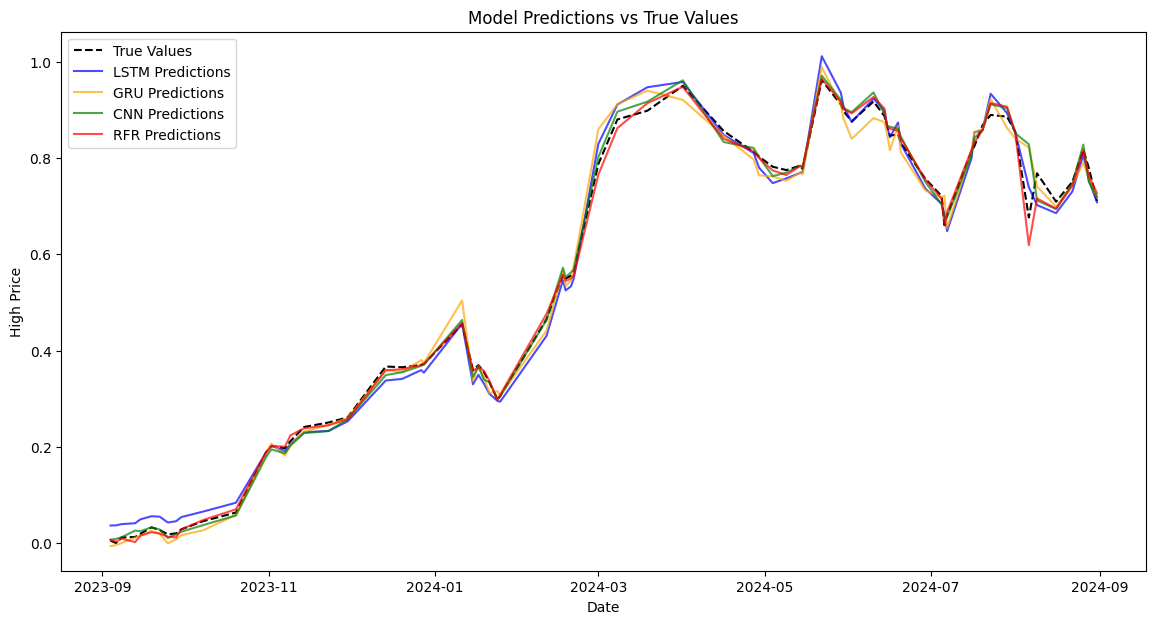

In [36]:
# Ensure the test indices are sorted to maintain chronological order
sorted_test_indices = np.sort(y_test.index)

# Flatten the predictions and ensure they match the shape of true values
lstm_predictions_flat = lstm_predictions.flatten()
gru_predictions_flat = gru_predictions.flatten()
cnn_predictions_flat = cnn_predictions.flatten()
rfr_predictions_flat = rfr_predictions.flatten()

# Sort predictions and true values by the same index ordering
sorted_y_test = y_test.loc[sorted_test_indices].values
sorted_dates = btc_etf_data.loc[sorted_test_indices, 'timestamp']  # Ensure 'timestamp' is the correct column name for dates

sorted_lstm_predictions = lstm_predictions_flat[np.argsort(y_test.index)]
sorted_gru_predictions = gru_predictions_flat[np.argsort(y_test.index)]
sorted_cnn_predictions = cnn_predictions_flat[np.argsort(y_test.index)]
sorted_rfr_predictions = rfr_predictions_flat[np.argsort(y_test.index)]

plt.figure(figsize=(14, 7))

# Plot true values
plt.plot(sorted_dates, sorted_y_test, label='True Values', color='black', linestyle='--')

# Plot predictions from each model
plt.plot(sorted_dates, sorted_lstm_predictions, label='LSTM Predictions', color='blue', alpha=0.7)
plt.plot(sorted_dates, sorted_gru_predictions, label='GRU Predictions', color='orange', alpha=0.7)
plt.plot(sorted_dates, sorted_cnn_predictions, label='CNN Predictions', color='green', alpha=0.7)
plt.plot(sorted_dates, sorted_rfr_predictions, label='RFR Predictions', color='red', alpha=0.7)

# Adding titles and labels
plt.title('Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()

# Show the plot
plt.show()

# Simulate trading strategy

Based on the predictions, we will now simulate a trading strategy with different risk-reward ratios (RRR). We will use the following parameters:
- Starting capital: $10,000
- Max risk: 1% of account balance. This means we can only risk 1% of the current capital for one trade. This also dictates the position size we can take.
- Max position size: 1000. To mimic real trading, we will not use all the predicted price increase. We will cap the position size at 1000.

We will test Trading strategies with RRR (Risk-Reward Ratio) of 2, 3, and 1.5. We are interested in the annualized return, max drawdown, win rate, and total trades.

In [37]:
# Ensure we're using normalized data for prediction
btc_pre_etf_data['predicted_high'] = rfr_model.predict(btc_pre_etf_data[['open', 'close', 'low', 'volume', 'marketCap']])

# Denormalize the predicted high values
min_high = btc_pre_etf_data_denormalized['high'].min()
max_high = btc_pre_etf_data_denormalized['high'].max()
btc_pre_etf_data_denormalized['predicted_high'] = btc_pre_etf_data['predicted_high'] * (max_high - min_high) + min_high

# Print sample data to understand the scale of our values
print("Sample data:")
print(btc_pre_etf_data_denormalized[['close', 'high', 'predicted_high']].head())
print("\nValue ranges:")
print(f"Close: {btc_pre_etf_data_denormalized['close'].min()} to {btc_pre_etf_data_denormalized['close'].max()}")
print(f"High: {btc_pre_etf_data_denormalized['high'].min()} to {btc_pre_etf_data_denormalized['high'].max()}")
print(f"Predicted High: {btc_pre_etf_data_denormalized['predicted_high'].min()} to {btc_pre_etf_data_denormalized['predicted_high'].max()}")

# Clip predictions to the range of original 'high' values
btc_pre_etf_data_denormalized['predicted_high'] = btc_pre_etf_data_denormalized['predicted_high'].clip(min_high, max_high)

print("\nAfter clipping:")
print(f"Predicted High: {btc_pre_etf_data_denormalized['predicted_high'].min()} to {btc_pre_etf_data_denormalized['predicted_high'].max()}")

Sample data:
          close          high  predicted_high
0  25931.472893  27456.079001    27195.688875
1  27297.265348  27760.159397    28112.012272
2  27727.393009  28089.338027    27197.940887
3  26106.150044  26198.579064    26285.003779
4  26089.693472  26165.372438    26304.231370

Value ranges:
Close: 178.1029968262 to 67566.8300878775
High: 211.7310028076 to 68789.6259389221
Predicted High: 321.43266455544165 to 66238.05357557227

After clipping:
Predicted High: 321.43266455544165 to 66238.05357557227


In [38]:
# Reverse the order of the data from start to end
btc_pre_etf_data_denormalized = btc_pre_etf_data_denormalized.iloc[::-1].reset_index(drop=True)

def simulate_trading_strategy(data, rrr, starting_balance=10000, max_risk_percent=0.01, max_position_size=200):
    account_balance = starting_balance
    trades = []
    max_balance = starting_balance
    
    for i in range(1, len(data)):
        if account_balance <= 0:
            break  # Stop trading if balance is depleted

        entry_price = data['close'].iloc[i - 1]
        predicted_high = data['predicted_high'].iloc[i]
        
        if predicted_high > entry_price:
            trade_direction = 'LONG'
            take_profit_price = predicted_high
            stop_loss_price = entry_price - (predicted_high - entry_price) / rrr
        elif predicted_high < entry_price:
            trade_direction = 'SHORT'
            take_profit_price = predicted_high
            stop_loss_price = entry_price + (entry_price - predicted_high) / rrr
        else:
            continue  # No trade if predicted high equals the previous close
        
        risk_amount = min(account_balance * max_risk_percent, account_balance)
        position_size = min(risk_amount / abs(entry_price - stop_loss_price), max_position_size)

        # Simulate the outcome of the trade
        if trade_direction == 'LONG':
            if data['high'].iloc[i] >= take_profit_price:
                profit = position_size * (take_profit_price - entry_price)
                exit_price = take_profit_price
            elif data['low'].iloc[i] <= stop_loss_price:
                profit = -risk_amount
                exit_price = stop_loss_price
            else:
                profit = position_size * (data['close'].iloc[i] - entry_price)
                exit_price = data['close'].iloc[i]
        else:  # SHORT
            if data['low'].iloc[i] <= take_profit_price:
                profit = position_size * (entry_price - take_profit_price)
                exit_price = take_profit_price
            elif data['high'].iloc[i] >= stop_loss_price:
                profit = -risk_amount
                exit_price = stop_loss_price
            else:
                profit = position_size * (entry_price - data['close'].iloc[i])
                exit_price = data['close'].iloc[i]
        
        account_balance += profit
        max_balance = max(max_balance, account_balance)
        
        trade = {
            'date': data.index[i],
            'direction': trade_direction,
            'entry': entry_price,
            'exit': exit_price,
            'take_profit': take_profit_price,
            'stop_loss': stop_loss_price,
            'profit': profit,
            'balance': account_balance
        }
        trades.append(trade)
    
    return account_balance, trades, max_balance

def analyze_strategy(final_balance, trade_history, max_balance, starting_balance, rrr):
    df_trades = pd.DataFrame(trade_history)
    total_trades = len(df_trades)
    winning_trades = sum(df_trades['profit'] > 0)
    losing_trades = sum(df_trades['profit'] < 0)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    max_drawdown = (max_balance - df_trades['balance'].min()) / max_balance * 100
    total_return = (final_balance / starting_balance - 1) * 100
    annualized_return = (final_balance / starting_balance) ** (1/10) - 1  # Assuming 10 years
    
    print(f"\nTrading Strategy (RRR {rrr}:1):")
    print(f"Starting Balance: ${starting_balance:,.2f}")
    print(f"Ending Balance: ${final_balance:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Losing Trades: {losing_trades}")
    
    return df_trades

# Run simulations for different RRR strategies
starting_balance = 10000
rrr_values = [2, 3, 1.5]
results = {}

for rrr in rrr_values:
    final_balance, trade_history, max_balance = simulate_trading_strategy(
        btc_pre_etf_data_denormalized, 
        rrr=rrr, 
        starting_balance=starting_balance, 
        max_risk_percent=0.01, 
        max_position_size=1000
    )
    df_trades = analyze_strategy(final_balance, trade_history, max_balance, starting_balance, rrr)
    results[rrr] = df_trades



Trading Strategy (RRR 2:1):
Starting Balance: $10,000.00
Ending Balance: $60,584,551.58
Total Return: 605745.52%
Annualized Return: 138.91%
Max Drawdown: 99.98%
Win Rate: 56.88%
Total Trades: 3277
Winning Trades: 1864
Losing Trades: 1412

Trading Strategy (RRR 3:1):
Starting Balance: $10,000.00
Ending Balance: $99,927,072.36
Total Return: 999170.72%
Annualized Return: 151.17%
Max Drawdown: 99.99%
Win Rate: 55.36%
Total Trades: 3277
Winning Trades: 1814
Losing Trades: 1462

Trading Strategy (RRR 1.5:1):
Starting Balance: $10,000.00
Ending Balance: $21,632,217.35
Total Return: 216222.17%
Annualized Return: 115.53%
Max Drawdown: 99.95%
Win Rate: 57.61%
Total Trades: 3277
Winning Trades: 1888
Losing Trades: 1388


## Benchmarking: buy-and-hold strategy to gain a better perspective on the performance of the trading strategies.

In [39]:
def simulate_buy_and_hold(data, starting_balance=10000):
    initial_price = data['close'].iloc[0]
    final_price = data['close'].iloc[-1]
    num_coins = starting_balance / initial_price
    final_balance = num_coins * final_price
    return final_balance

# Calculate buy-and-hold balance over time
buy_and_hold_balance = 10000 * btc_pre_etf_data_denormalized['close'] / btc_pre_etf_data_denormalized['close'].iloc[0]

print(f"Buy-and-Hold Strategy:")
print(f"Starting Balance: ${buy_and_hold_balance.iloc[0]:,.2f}")
print(f"Ending Balance: ${buy_and_hold_balance.iloc[-1]:,.2f}")
print(f"Total Return: {(buy_and_hold_balance.iloc[-1] / buy_and_hold_balance.iloc[0] - 1) * 100:.2f}%")

Buy-and-Hold Strategy:
Starting Balance: $10,000.00
Ending Balance: $543,151.68
Total Return: 5331.52%


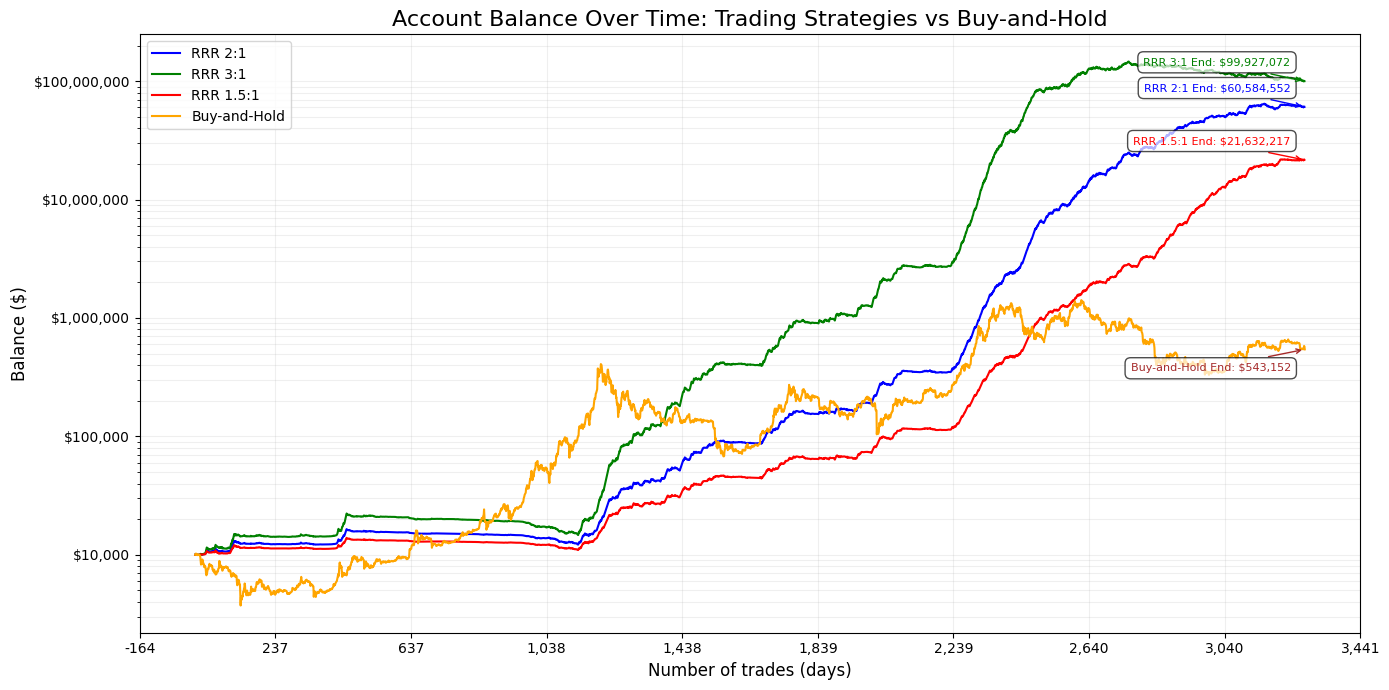

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot trading strategies
colors = ['blue', 'green', 'red']
for rrr, color in zip(results.keys(), colors):
    ax.plot(range(len(results[rrr])), results[rrr]['balance'], label=f'RRR {rrr}:1', color=color)

# Plot buy-and-hold balance
ax.plot(range(len(btc_pre_etf_data_denormalized)), buy_and_hold_balance, label='Buy-and-Hold', color='orange')

# Set title and labels
ax.set_title('Account Balance Over Time: Trading Strategies vs Buy-and-Hold', fontsize=16)
ax.set_xlabel('Number of trades (days)', fontsize=12)
ax.set_ylabel('Balance ($)', fontsize=12)

# Set y-axis to log scale
ax.set_yscale('log')

# Format y-axis labels
def currency_formatter(x, p):
    return f'${x:,.0f}'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

# Improve x-axis ticks
num_ticks = 10
ax.xaxis.set_major_locator(ticker.LinearLocator(num_ticks))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Add grid
ax.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
ax.legend(fontsize=10)

# Annotate end points for trading strategies
for rrr, color in zip(results.keys(), colors):
    ax.annotate(f'RRR {rrr}:1 End: ${results[rrr]["balance"].iloc[-1]:,.0f}', 
                xy=(len(results[rrr])-1, results[rrr]['balance'].iloc[-1]), 
                xytext=(-10, 10), 
                textcoords='offset points', 
                ha='right', 
                va='bottom',
                fontsize=8,
                color=color,
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', color=color))

# Annotate end point for buy-and-hold
ax.annotate(f'Buy-and-Hold End: ${buy_and_hold_balance.iloc[-1]:,.0f}', 
            xy=(len(btc_pre_etf_data_denormalized)-1, buy_and_hold_balance.iloc[-1]), 
            xytext=(-10, -10), 
            textcoords='offset points', 
            ha='right', 
            va='top',
            fontsize=8,
            color='brown',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', color='brown'))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Comparison of trading strategies to buy-and-hold strategy

- As we can see from the plot, the trading strategies perform way better than the buy-and-hold strategy. However, while this might be shocking, the models performed great on the training data and might not be reflective of the future performance. 
- What is interesting is that different RRR strategies had similar win rate, but different returns on investement. This is expected as the each strategy has different upside potential, but same risk. In reality, we should see worse winrate for the 3:1 RRR strategy, as it has higher potential returns, and higher win rate for 1.5:1 RRR strategy, as it has lower potential returns. This almost implies that the sky would be limit here, but of course, this could be only evaluated on the future data.

# Post ETF Bitcoin prediction

In [41]:
# Ensure we're using normalized data for prediction
btc_etf_data['predicted_high'] = rfr_model.predict(btc_etf_data[['open', 'close', 'low', 'volume', 'marketCap']])

# Denormalize the predicted high values
min_high = btc_etf_data_denormalized['high'].min()
max_high = btc_etf_data_denormalized['high'].max()
btc_etf_data_denormalized['predicted_high'] = btc_etf_data['predicted_high'] * (max_high - min_high) + min_high



# Clip predictions to the range of original 'high' values
btc_pre_etf_data_denormalized['predicted_high'] = btc_pre_etf_data_denormalized['predicted_high'].clip(min_high, max_high)



In [42]:
# Reverse the order of the data from start to end
btc_etf_data_denormalized = btc_etf_data_denormalized.iloc[::-1].reset_index(drop=True)

def simulate_trading_strategy(data, rrr, starting_balance=10000, max_risk_percent=0.01, max_position_size=200):
    account_balance = starting_balance
    trades = []
    max_balance = starting_balance
    
    for i in range(1, len(data)):
        if account_balance <= 0:
            break  # Stop trading if balance is depleted

        entry_price = data['close'].iloc[i - 1]
        predicted_high = data['predicted_high'].iloc[i]
        
        if predicted_high > entry_price:
            trade_direction = 'LONG'
            take_profit_price = predicted_high
            stop_loss_price = entry_price - (predicted_high - entry_price) / rrr
        elif predicted_high < entry_price:
            trade_direction = 'SHORT'
            take_profit_price = predicted_high
            stop_loss_price = entry_price + (entry_price - predicted_high) / rrr
        else:
            continue  # No trade if predicted high equals the previous close
        
        risk_amount = min(account_balance * max_risk_percent, account_balance)
        position_size = min(risk_amount / abs(entry_price - stop_loss_price), max_position_size)

        # Simulate the outcome of the trade
        if trade_direction == 'LONG':
            if data['high'].iloc[i] >= take_profit_price:
                profit = position_size * (take_profit_price - entry_price)
                exit_price = take_profit_price
            elif data['low'].iloc[i] <= stop_loss_price:
                profit = -risk_amount
                exit_price = stop_loss_price
            else:
                profit = position_size * (data['close'].iloc[i] - entry_price)
                exit_price = data['close'].iloc[i]
        else:  # SHORT
            if data['low'].iloc[i] <= take_profit_price:
                profit = position_size * (entry_price - take_profit_price)
                exit_price = take_profit_price
            elif data['high'].iloc[i] >= stop_loss_price:
                profit = -risk_amount
                exit_price = stop_loss_price
            else:
                profit = position_size * (entry_price - data['close'].iloc[i])
                exit_price = data['close'].iloc[i]
        
        account_balance += profit
        max_balance = max(max_balance, account_balance)
        
        trade = {
            'date': data.index[i],
            'direction': trade_direction,
            'entry': entry_price,
            'exit': exit_price,
            'take_profit': take_profit_price,
            'stop_loss': stop_loss_price,
            'profit': profit,
            'balance': account_balance
        }
        trades.append(trade)
    
    return account_balance, trades, max_balance

def analyze_strategy(final_balance, trade_history, max_balance, starting_balance, rrr):
    df_trades = pd.DataFrame(trade_history)
    total_trades = len(df_trades)
    winning_trades = sum(df_trades['profit'] > 0)
    losing_trades = sum(df_trades['profit'] < 0)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    max_drawdown = (max_balance - df_trades['balance'].min()) / max_balance * 100
    total_return = (final_balance / starting_balance - 1) * 100
    annualized_return = (final_balance / starting_balance) ** (1/10) - 1  # Assuming 10 years
    
    print(f"\nTrading Strategy (RRR {rrr}:1):")
    print(f"Starting Balance: ${starting_balance:,.2f}")
    print(f"Ending Balance: ${final_balance:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Losing Trades: {losing_trades}")
    
    return df_trades

# Run simulations for different RRR strategies
starting_balance = 10000
rrr_values = [2, 3, 1.5]
results = {}

for rrr in rrr_values:
    final_balance, trade_history, max_balance = simulate_trading_strategy(
        btc_etf_data_denormalized, 
        rrr=rrr, 
        starting_balance=starting_balance, 
        max_risk_percent=0.01, 
        max_position_size=1000
    )
    df_trades = analyze_strategy(final_balance, trade_history, max_balance, starting_balance, rrr)
    results[rrr] = df_trades



Trading Strategy (RRR 2:1):
Starting Balance: $10,000.00
Ending Balance: $259,007.21
Total Return: 2490.07%
Annualized Return: 38.46%
Max Drawdown: 96.16%
Win Rate: 69.15%
Total Trades: 363
Winning Trades: 251
Losing Trades: 112

Trading Strategy (RRR 3:1):
Starting Balance: $10,000.00
Ending Balance: $1,614,421.13
Total Return: 16044.21%
Annualized Return: 66.27%
Max Drawdown: 99.38%
Win Rate: 65.01%
Total Trades: 363
Winning Trades: 236
Losing Trades: 127

Trading Strategy (RRR 1.5:1):
Starting Balance: $10,000.00
Ending Balance: $105,125.90
Total Return: 951.26%
Annualized Return: 26.52%
Max Drawdown: 90.59%
Win Rate: 71.07%
Total Trades: 363
Winning Trades: 258
Losing Trades: 105


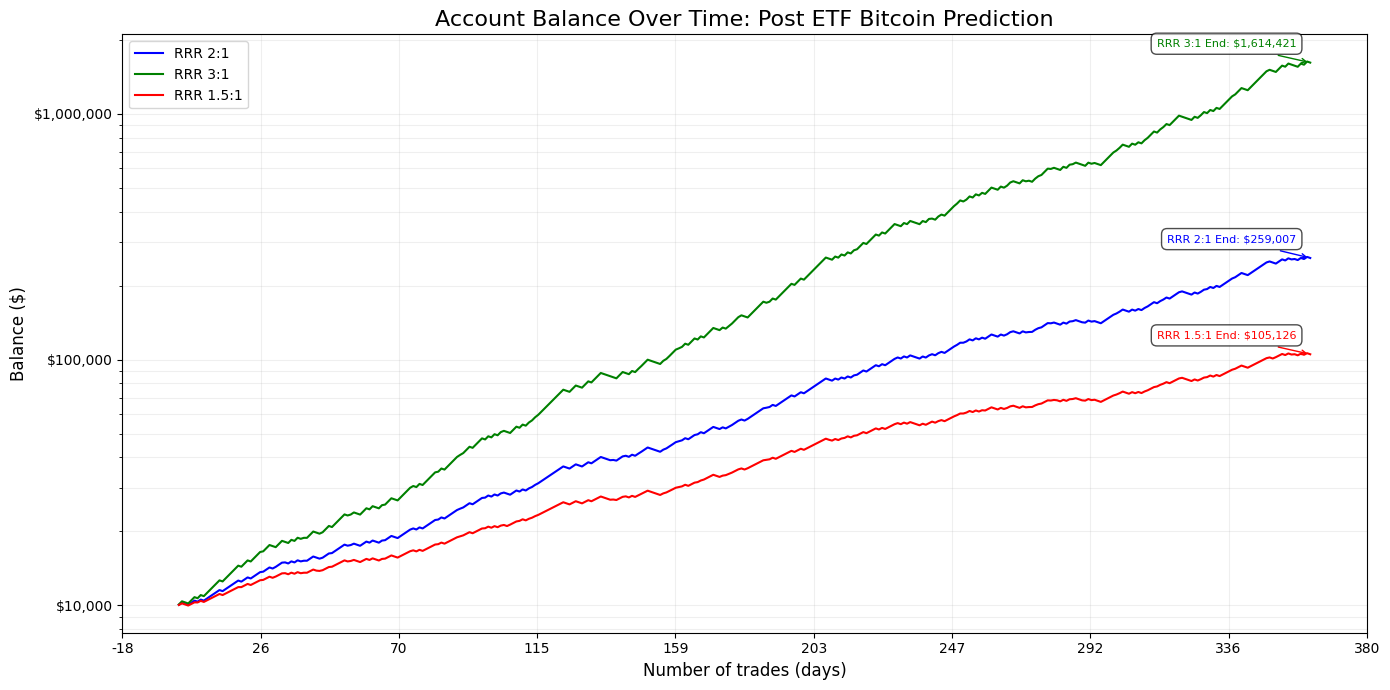

In [43]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot trading strategies
colors = ['blue', 'green', 'red']
for rrr, color in zip(results.keys(), colors):
    ax.plot(range(len(results[rrr])), results[rrr]['balance'], label=f'RRR {rrr}:1', color=color)


# Set title and labels
ax.set_title('Account Balance Over Time: Post ETF Bitcoin Prediction', fontsize=16)
ax.set_xlabel('Number of trades (days)', fontsize=12)
ax.set_ylabel('Balance ($)', fontsize=12)

# Set y-axis to log scale
ax.set_yscale('log')

# Format y-axis labels
def currency_formatter(x, p):
    return f'${x:,.0f}'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

# Improve x-axis ticks
num_ticks = 10
ax.xaxis.set_major_locator(ticker.LinearLocator(num_ticks))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Add grid
ax.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
ax.legend(fontsize=10)

# Annotate end points for trading strategies
for rrr, color in zip(results.keys(), colors):
    ax.annotate(f'RRR {rrr}:1 End: ${results[rrr]["balance"].iloc[-1]:,.0f}', 
                xy=(len(results[rrr])-1, results[rrr]['balance'].iloc[-1]), 
                xytext=(-10, 10), 
                textcoords='offset points', 
                ha='right', 
                va='bottom',
                fontsize=8,
                color=color,
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', color=color))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Price prediction for Ethereum

Taking the learnings from Bitcoin, the intent is to use the same model to predict the price of Ethereum and compare the results.

### Data loading and preprocessing

In [44]:
# Load the CSV file with the correct delimiter
ethereum_data_path = './jupyter notebook/data/ethereum-sep2023-aug2024.csv'
eth_data = pd.read_csv(ethereum_data_path, delimiter=';', skipinitialspace=True)

# Convert time columns to datetime
eth_data['timeOpen'] = pd.to_datetime(eth_data['timeOpen'], errors='coerce')
eth_data['timeClose'] = pd.to_datetime(eth_data['timeClose'], errors='coerce')
eth_data['timeHigh'] = pd.to_datetime(eth_data['timeHigh'], errors='coerce')
eth_data['timeLow'] = pd.to_datetime(eth_data['timeLow'], errors='coerce')
eth_data['timestamp'] = pd.to_datetime(eth_data['timestamp'], errors='coerce')

# Convert relevant columns to numeric, coercing errors to NaN
numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'marketCap']
eth_data[numeric_columns] = eth_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

eth_data_denormalized = eth_data.copy()
# Data normalization for numeric columns
scaler = MinMaxScaler()
eth_data[numeric_columns] = scaler.fit_transform(eth_data[numeric_columns])

# Display the first few rows of the processed DataFrame
eth_data_denormalized.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2024-08-31 00:00:00+00:00,2024-08-31 23:59:59.999000+00:00,2024-08-31 00:35:00+00:00,2024-08-31 17:53:00+00:00,2781,2525.859140,2532.389995,2493.705631,2513.393740,6.646876e+09,3.023734e+11,2024-08-31 23:59:59.999000+00:00
1,2024-08-30 00:00:00+00:00,2024-08-30 23:59:59.999000+00:00,2024-08-30 18:41:00+00:00,2024-08-30 16:28:00+00:00,2781,2528.732138,2539.915174,2432.834366,2525.821919,1.552622e+10,3.038585e+11,2024-08-30 23:59:59.999000+00:00
2,2024-08-29 00:00:00+00:00,2024-08-29 23:59:59.999000+00:00,2024-08-29 15:35:00+00:00,2024-08-29 22:10:00+00:00,2781,2528.362339,2595.976950,2507.502461,2528.792715,1.394643e+10,3.042028e+11,2024-08-29 23:59:59.999000+00:00
3,2024-08-28 00:00:00+00:00,2024-08-28 23:59:59.999000+00:00,2024-08-28 21:27:00+00:00,2024-08-28 01:38:00+00:00,2781,2458.904729,2553.820133,2422.293631,2528.415504,2.035955e+10,3.041587e+11,2024-08-28 23:59:59.999000+00:00
4,2024-08-27 00:00:00+00:00,2024-08-27 23:59:59.999000+00:00,2024-08-27 05:52:00+00:00,2024-08-27 22:16:00+00:00,2781,2681.622855,2700.152794,2401.175001,2458.726473,1.802900e+10,2.958036e+11,2024-08-27 23:59:59.999000+00:00


In [45]:
# Prepare the dataset for training
X = eth_data[['open', 'close', 'low', 'volume', 'marketCap']]
y = eth_data['high']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Bitcoin and Ethereum correlation

As we can see from the correlation matrix, the features are not very correlated, with the exception of the marketCap. This is expected, as Bitcoin and Ethereum are different coins with different use market capitalization.

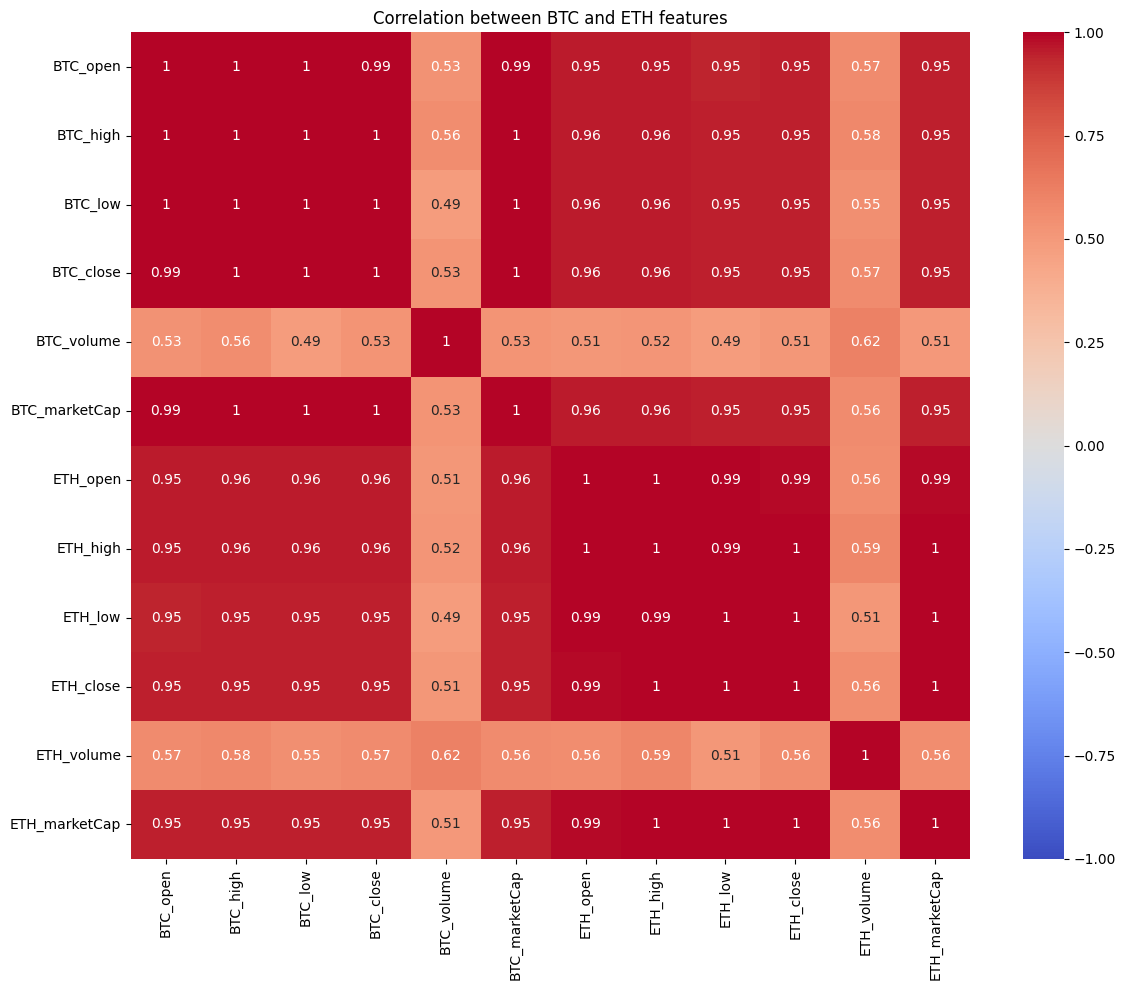

Correlation between BTC and ETH closing prices: 0.9524
Correlation between BTC and ETH open: 0.9534
Correlation between BTC and ETH high: 0.9566
Correlation between BTC and ETH low: 0.9509
Correlation between BTC and ETH close: 0.9524
Correlation between BTC and ETH volume: 0.6165
Correlation between BTC and ETH marketCap: 0.9518

Most correlated feature between BTC and ETH: high (0.9566)
Least correlated feature between BTC and ETH: volume (0.6165)


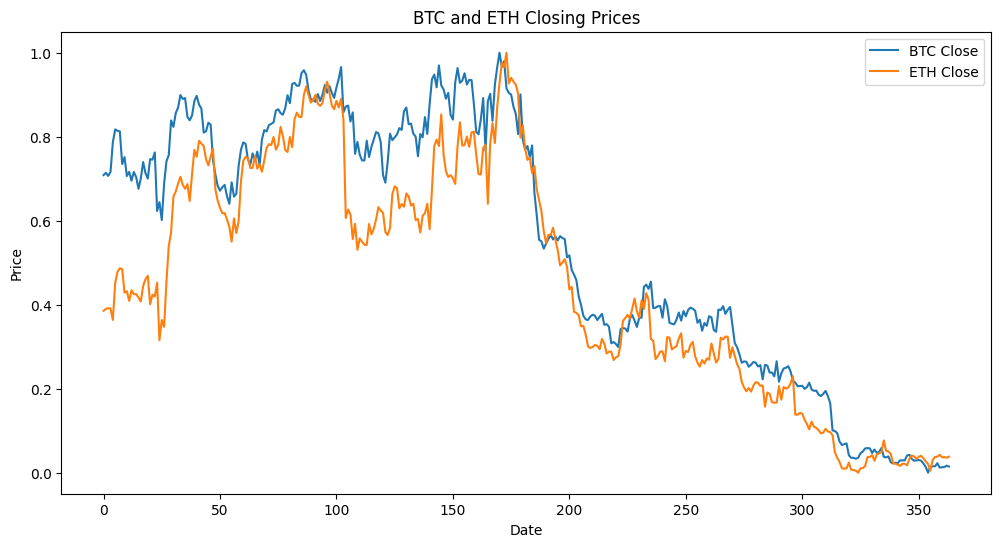

In [46]:
# Ensure both datasets have the same date range
start_date = max(btc_etf_data.index.min(), eth_data.index.min())
end_date = min(btc_etf_data.index.max(), eth_data.index.max())

btc_data = btc_etf_data.loc[start_date:end_date]
eth_data = eth_data.loc[start_date:end_date]

# Select common numerical features
common_features = ['open', 'high', 'low', 'close', 'volume', 'marketCap']

# Create a combined dataframe
combined_data = pd.DataFrame({
    'BTC_' + col: btc_data[col] for col in common_features
})
combined_data = combined_data.join(pd.DataFrame({
    'ETH_' + col: eth_data[col] for col in common_features
}))

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between BTC and ETH features')
plt.tight_layout()
plt.show()

# Print the correlation between BTC and ETH closing prices
btc_eth_close_corr = correlation_matrix.loc['BTC_close', 'ETH_close']
print(f"Correlation between BTC and ETH closing prices: {btc_eth_close_corr:.4f}")

# Calculate and print the average correlation for each feature across BTC and ETH
avg_correlations = {}
for feature in common_features:
    corr = correlation_matrix.loc[f'BTC_{feature}', f'ETH_{feature}']
    avg_correlations[feature] = corr
    print(f"Correlation between BTC and ETH {feature}: {corr:.4f}")

# Find the most and least correlated features
most_correlated = max(avg_correlations, key=avg_correlations.get)
least_correlated = min(avg_correlations, key=avg_correlations.get)

print(f"\nMost correlated feature between BTC and ETH: {most_correlated} ({avg_correlations[most_correlated]:.4f})")
print(f"Least correlated feature between BTC and ETH: {least_correlated} ({avg_correlations[least_correlated]:.4f})")

plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data['close'], label='BTC Close')
plt.plot(eth_data.index, eth_data['close'], label='ETH Close')
plt.title('BTC and ETH Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Ethereum price prediction

In [47]:
# Initialize the Random Forest Regressor model
rfr_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, criterion='squared_error')

# Train the Random Forest Regressor on the training data
rfr_model.fit(X_train, y_train)

# Make predictions with the Random Forest Regressor
rfr_predictions = rfr_model.predict(X_test)

# Evaluate the Random Forest Regressor model
rfr_mae = mean_absolute_error(y_test, rfr_predictions)
rfr_rmse = np.sqrt(mean_squared_error(y_test, rfr_predictions))
rfr_r2 = r2_score(y_test, rfr_predictions)

# Print the evaluation metrics for the Random Forest Regressor model
print(f'RFR MAE: {rfr_mae:.4f}')
print(f'RFR RMSE: {rfr_rmse:.4f}')
print(f'RFR R-squared: {rfr_r2:.4f}')

RFR MAE: 0.0084
RFR RMSE: 0.0110
RFR R-squared: 0.9986


In [48]:
# Ensure we're using normalized data for prediction
eth_data['predicted_high'] = rfr_model.predict(eth_data[['open', 'close', 'low', 'volume', 'marketCap']])

# Denormalize the predicted high values
min_high = eth_data_denormalized['high'].min()
max_high = eth_data_denormalized['high'].max()
eth_data_denormalized['predicted_high'] = eth_data['predicted_high'] * (max_high - min_high) + min_high

# Clip predictions to the range of original 'high' values
eth_data_denormalized['predicted_high'] = eth_data_denormalized['predicted_high'].clip(min_high, max_high)


In [49]:
# Reverse the order of the data from start to end
eth_data_denormalized = eth_data_denormalized.iloc[::-1].reset_index(drop=True)

def simulate_trading_strategy(data, rrr, starting_balance=10000, max_risk_percent=0.01, max_position_size=200):
    account_balance = starting_balance
    trades = []
    max_balance = starting_balance
    
    for i in range(1, len(data)):
        if account_balance <= 0:
            break  # Stop trading if balance is depleted

        entry_price = data['close'].iloc[i - 1]
        predicted_high = data['predicted_high'].iloc[i]
        
        if predicted_high > entry_price:
            trade_direction = 'LONG'
            take_profit_price = predicted_high
            stop_loss_price = entry_price - (predicted_high - entry_price) / rrr
        elif predicted_high < entry_price:
            trade_direction = 'SHORT'
            take_profit_price = predicted_high
            stop_loss_price = entry_price + (entry_price - predicted_high) / rrr
        else:
            continue  # No trade if predicted high equals the previous close
        
        risk_amount = min(account_balance * max_risk_percent, account_balance)
        position_size = min(risk_amount / abs(entry_price - stop_loss_price), max_position_size)

        # Simulate the outcome of the trade
        if trade_direction == 'LONG':
            if data['high'].iloc[i] >= take_profit_price:
                profit = position_size * (take_profit_price - entry_price)
                exit_price = take_profit_price
            elif data['low'].iloc[i] <= stop_loss_price:
                profit = -risk_amount
                exit_price = stop_loss_price
            else:
                profit = position_size * (data['close'].iloc[i] - entry_price)
                exit_price = data['close'].iloc[i]
        else:  # SHORT
            if data['low'].iloc[i] <= take_profit_price:
                profit = position_size * (entry_price - take_profit_price)
                exit_price = take_profit_price
            elif data['high'].iloc[i] >= stop_loss_price:
                profit = -risk_amount
                exit_price = stop_loss_price
            else:
                profit = position_size * (entry_price - data['close'].iloc[i])
                exit_price = data['close'].iloc[i]
        
        account_balance += profit
        max_balance = max(max_balance, account_balance)
        
        trade = {
            'date': data.index[i],
            'direction': trade_direction,
            'entry': entry_price,
            'exit': exit_price,
            'take_profit': take_profit_price,
            'stop_loss': stop_loss_price,
            'profit': profit,
            'balance': account_balance
        }
        trades.append(trade)
    
    return account_balance, trades, max_balance

def analyze_strategy(final_balance, trade_history, max_balance, starting_balance, rrr):
    df_trades = pd.DataFrame(trade_history)
    total_trades = len(df_trades)
    winning_trades = sum(df_trades['profit'] > 0)
    losing_trades = sum(df_trades['profit'] < 0)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    max_drawdown = (max_balance - df_trades['balance'].min()) / max_balance * 100
    total_return = (final_balance / starting_balance - 1) * 100
    annualized_return = (final_balance / starting_balance) ** (1/10) - 1  # Assuming 10 years
    
    print(f"\nTrading Strategy (RRR {rrr}:1):")
    print(f"Starting Balance: ${starting_balance:,.2f}")
    print(f"Ending Balance: ${final_balance:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Losing Trades: {losing_trades}")
    
    return df_trades

# Run simulations for different RRR strategies
starting_balance = 10000
rrr_values = [2, 3, 1.5]
results = {}

for rrr in rrr_values:
    final_balance, trade_history, max_balance = simulate_trading_strategy(
        eth_data_denormalized, 
        rrr=rrr, 
        starting_balance=starting_balance, 
        max_risk_percent=0.01, 
        max_position_size=1000
    )
    df_trades = analyze_strategy(final_balance, trade_history, max_balance, starting_balance, rrr)
    results[rrr] = df_trades



Trading Strategy (RRR 2:1):
Starting Balance: $10,000.00
Ending Balance: $215,709.54
Total Return: 2057.10%
Annualized Return: 35.95%
Max Drawdown: 95.50%
Win Rate: 67.58%
Total Trades: 364
Winning Trades: 246
Losing Trades: 118

Trading Strategy (RRR 3:1):
Starting Balance: $10,000.00
Ending Balance: $1,049,501.78
Total Return: 10395.02%
Annualized Return: 59.26%
Max Drawdown: 99.08%
Win Rate: 64.29%
Total Trades: 364
Winning Trades: 234
Losing Trades: 130

Trading Strategy (RRR 1.5:1):
Starting Balance: $10,000.00
Ending Balance: $87,146.60
Total Return: 771.47%
Annualized Return: 24.17%
Max Drawdown: 88.87%
Win Rate: 69.78%
Total Trades: 364
Winning Trades: 254
Losing Trades: 110


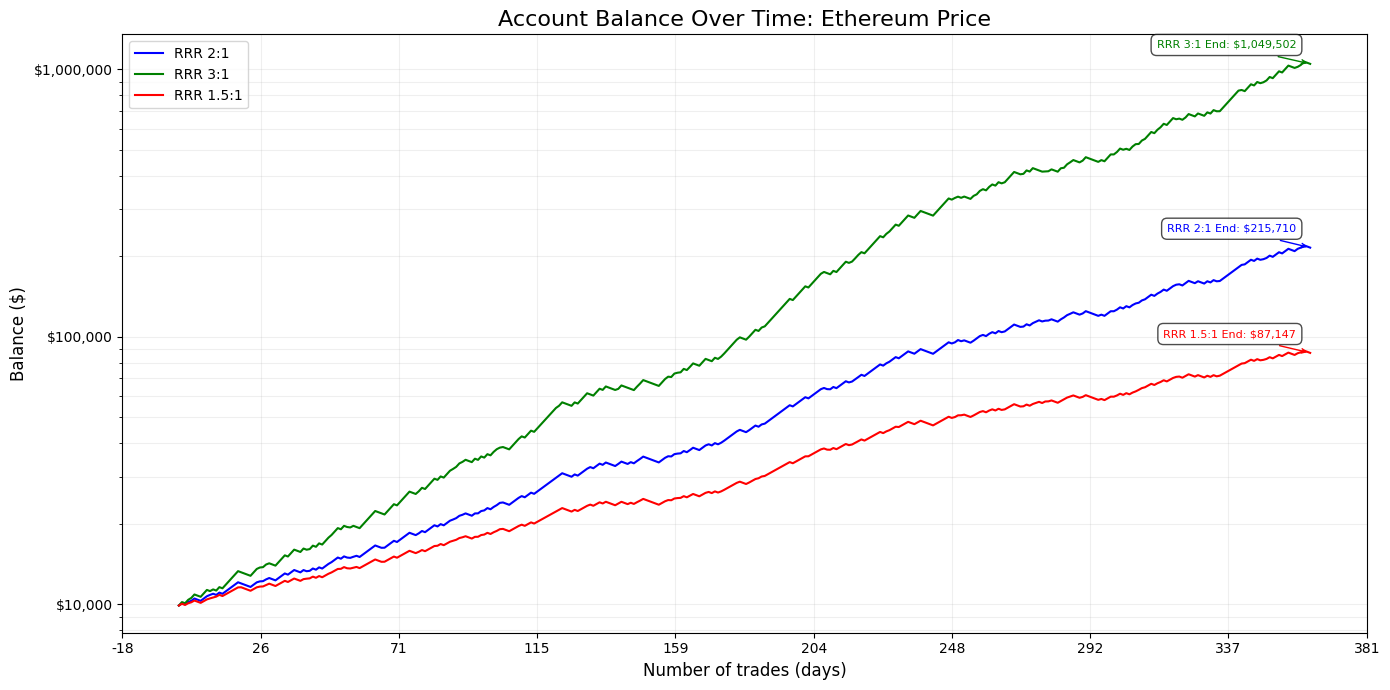

In [50]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot trading strategies
colors = ['blue', 'green', 'red']
for rrr, color in zip(results.keys(), colors):
    ax.plot(range(len(results[rrr])), results[rrr]['balance'], label=f'RRR {rrr}:1', color=color)


# Set title and labels
ax.set_title('Account Balance Over Time: Ethereum Price', fontsize=16)
ax.set_xlabel('Number of trades (days)', fontsize=12)
ax.set_ylabel('Balance ($)', fontsize=12)

# Set y-axis to log scale
ax.set_yscale('log')

# Format y-axis labels
def currency_formatter(x, p):
    return f'${x:,.0f}'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

# Improve x-axis ticks
num_ticks = 10
ax.xaxis.set_major_locator(ticker.LinearLocator(num_ticks))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Add grid
ax.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
ax.legend(fontsize=10)

# Annotate end points for trading strategies
for rrr, color in zip(results.keys(), colors):
    ax.annotate(f'RRR {rrr}:1 End: ${results[rrr]["balance"].iloc[-1]:,.0f}', 
                xy=(len(results[rrr])-1, results[rrr]['balance'].iloc[-1]), 
                xytext=(-10, 10), 
                textcoords='offset points', 
                ha='right', 
                va='bottom',
                fontsize=8,
                color=color,
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', color=color))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Ethereum price prediction and trading strategies

As expected Ethereum price prediction and trading strategies perform similarly to Bitcoin because their features are highly correlated.

# Conclusion

I've succesfully implemented Bitcoin and Ethereum price prediction models and tested trading strategies on them. On historical data the models perform exceptonially well if we look at the outcome of the trading strategies. Price predictions itself doesn't have to be right more than 50% of the time to become profitable. However
However, we must keep in mind that past performance does not guarantee future results. The universal truth about trading applies here as well, even though we might see the promising performance, the ability to let this run on live markets would largely depend on individual's risk appetite and psychological make-up.

Predictions like these could be still useful for additional context and becoming a pieco of puzzle for decisions about entering the trade. 